# Import Libs

In [ ]:
# import modules in the Python program
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
import shutil
import sys
import os.path
import pandas_datareader as pdr
from datetime import datetime
import time
import warnings

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

# import packages that are specific to stock analysis or trading.
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.9 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 41.5MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 726.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.9 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=425b8c688058bb85fb739ad5a51369423950bade90c1486933106d96

# 1 - Data Preparation and EDA


## 1.1 Data Retrieval and Cleaning

In [ ]:
#data retrieval

# Assign the ticker list that we to collect from a data source
tickers_list = ['BXP','MAA','CCI','CLX','COST','KO','XEL','EIX','ES']
# Retrieve historical price data for each stock, which will later be matched up with a news score
stock_price = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}
stock_price

{'BXP':                   open        high         low       close    adjclose  \
 2017-01-03  127.699997  127.930000  125.989998  127.180000  101.391769   
 2017-01-04  127.660004  131.610001  127.220001  131.220001  104.612595   
 2017-01-05  130.199997  132.550003  128.759995  131.850006  105.114830   
 2017-01-06  131.589996  132.509995  131.210007  131.550003  104.875671   
 2017-01-09  131.059998  131.399994  129.960007  130.240005  103.831299   
 ...                ...         ...         ...         ...         ...   
 2021-12-23  114.559998  115.220001  113.480003  114.260002  106.205078   
 2021-12-27  114.260002  115.940002  113.430000  115.900002  107.729462   
 2021-12-28  115.370003  116.279999  114.510002  115.309998  107.181046   
 2021-12-29  115.669998  115.919998  114.089996  115.580002  107.432022   
 2021-12-30  115.000000  116.760002  114.870003  115.720001  108.481972   
 
              volume ticker  
 2017-01-03   813900    BXP  
 2017-01-04  1323500    BXP  
 

In [ ]:
#DATACLEANING
# Let's extract only the "adjclose" data that is needed for analysis, likely from the dataset
# Get the adjclose price for BXP
prep_data = pd.DataFrame(stock_price['BXP']['adjclose']).rename(columns = {"adjclose":"BXP"})

#Combine the remaining selected companies ticker symbols
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(stock_price[i]['adjclose'])
prep_data

,BXP,MAA,CCI,CLX,COST,KO,XEL,EIX,ES
2017-01-03,101.391769,78.806534,69.542847,101.861946,141.398956,34.231304,33.921459,55.877979,45.751350
2017-01-04,104.612595,79.527199,69.959457,102.627884,141.425507,34.108471,34.071785,56.353039,45.909176
2017-01-05,105.114830,79.421944,69.895363,103.276001,144.213989,34.190365,34.071785,56.150543,45.917480
2017-01-06,104.875671,79.357155,68.501297,103.124474,144.143219,34.182178,34.172001,55.831261,45.900871
2017-01-09,103.831299,78.871323,68.685585,102.097618,142.496674,33.838226,33.654240,55.309460,45.327736
...,...,...,...,...,...,...,...,...,...
2021-12-23,106.205078,211.455811,189.848541,162.153305,545.762146,56.116596,64.288246,63.409554,86.035637
2021-12-27,107.729462,214.841553,194.952042,163.165375,558.752380,56.531059,64.490921,63.362705,85.824020
2021-12-28,107.181046,215.864914,196.427887,164.158371,559.912659,56.752754,65.263039,63.906178,86.632042
2021-12-29,107.432022,218.361191,197.380035,163.633240,563.016479,56.820217,65.591194,64.131081,87.161110


## 1.2 Time Series Visualizations






In [ ]:
# Create return features for each ticker,
# We will use percentage change(pct_change) calculation as the return metric for the stocks being analyzed
return_data = pd.DataFrame()
for i in tickers_list:
  return_data[i] = prep_data[i].pct_change()
# Drop the null values in the dataset
return_data.dropna(inplace=True)
return_data

,BXP,MAA,CCI,CLX,COST,KO,XEL,EIX,ES
2017-01-04,0.031766,0.009145,0.005991,0.007519,0.000188,-0.003588,0.004432,0.008502,0.003450
2017-01-05,0.004801,-0.001324,-0.000916,0.006315,0.019717,0.002401,0.000000,-0.003593,0.000181
2017-01-06,-0.002275,-0.000816,-0.019945,-0.001467,-0.000491,-0.000239,0.002941,-0.005686,-0.000362
2017-01-09,-0.009958,-0.006122,0.002690,-0.009957,-0.011423,-0.010062,-0.015152,-0.009346,-0.012486
2017-01-10,-0.011133,0.001026,-0.015980,-0.015828,0.004286,-0.006777,-0.000248,0.001267,-0.005314
...,...,...,...,...,...,...,...,...,...
2021-12-23,-0.003575,-0.004951,-0.000952,-0.005504,0.001274,0.000687,-0.001798,0.000739,0.001007
2021-12-27,0.014353,0.016012,0.026882,0.006241,0.023802,0.007386,0.003153,-0.000739,-0.002460
2021-12-28,-0.005091,0.004763,0.007570,0.006086,0.002077,0.003922,0.011973,0.008577,0.009415
2021-12-29,0.002342,0.011564,0.004847,-0.003199,0.005543,0.001189,0.005028,0.003519,0.006107


In [ ]:
return_data.shape

(1257, 9)

Data Visualization

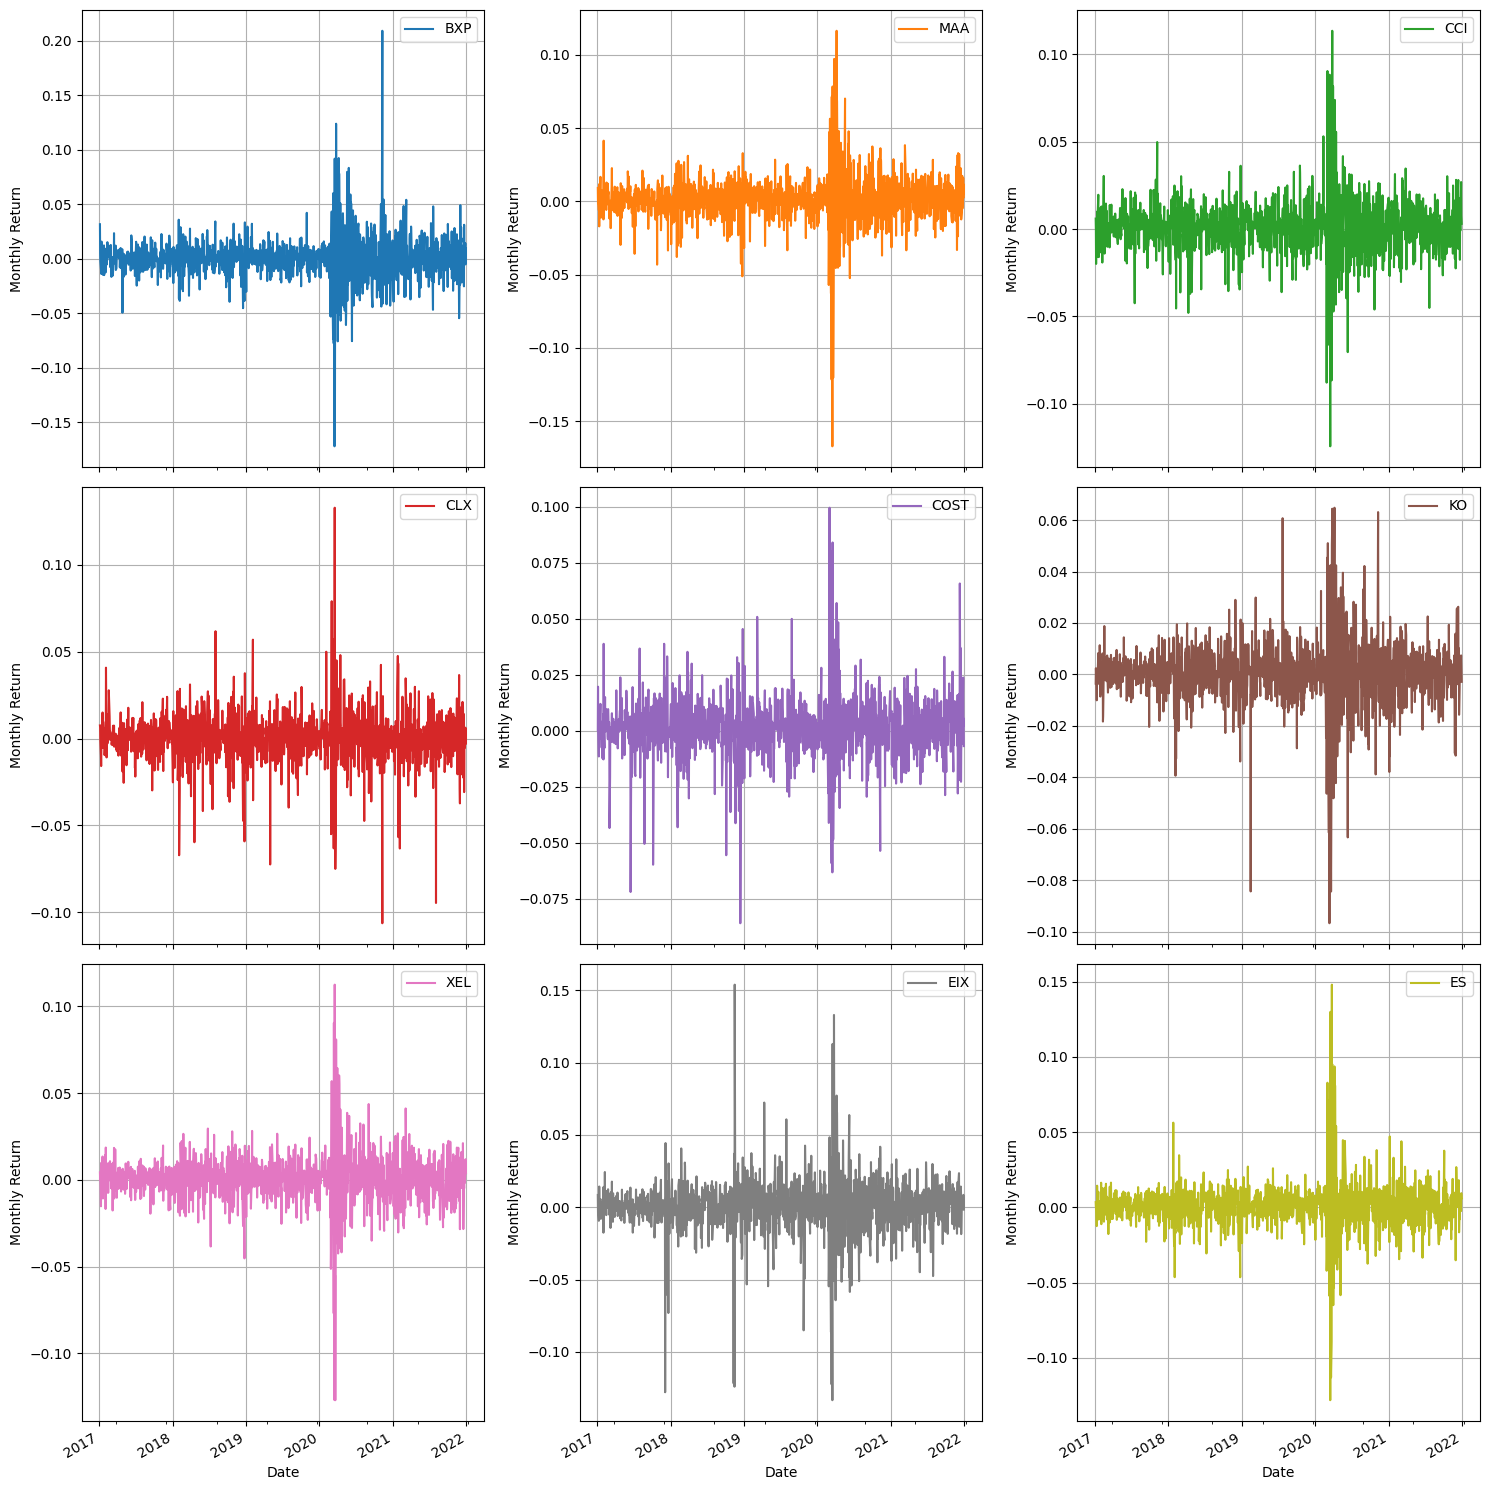

In [ ]:
# Display monthly return data, with each subplot displaying the return data for a different ticker
return_data.plot(subplots=True,
        grid=True,
        layout=(3,3),
        xlabel='Date',
        ylabel='Monthly Return',
         figsize=(15,15))
plt.tight_layout()
plt.show()

### 1.2.1 Visualization of Real Estates sector


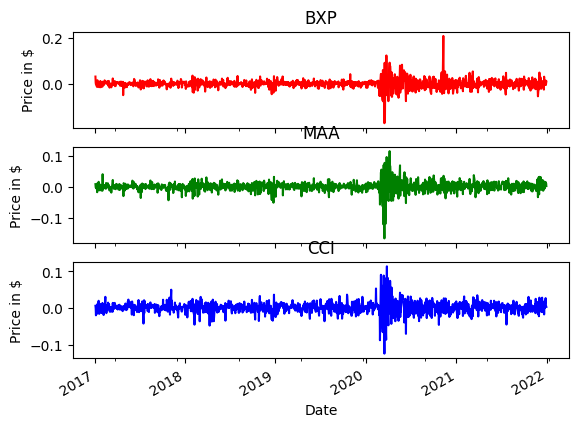

In [ ]:
# Draw subplot showing the historical price data for a different stock, identified by the stock ticker in real estate sector
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

return_data['BXP'].plot(ax=ax1, color='red')
ax1.set_title('BXP')
ax1.set_ylabel('Price in $')

return_data['MAA'].plot(ax=ax2, color='green')
ax2.set_title('MAA')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price in $')

return_data["CCI"].plot(ax=ax3, color='blue')
ax3.set_title("CCI")
ax3.set_xlabel('Date')
ax3.set_ylabel('Price in $')

plt.show()


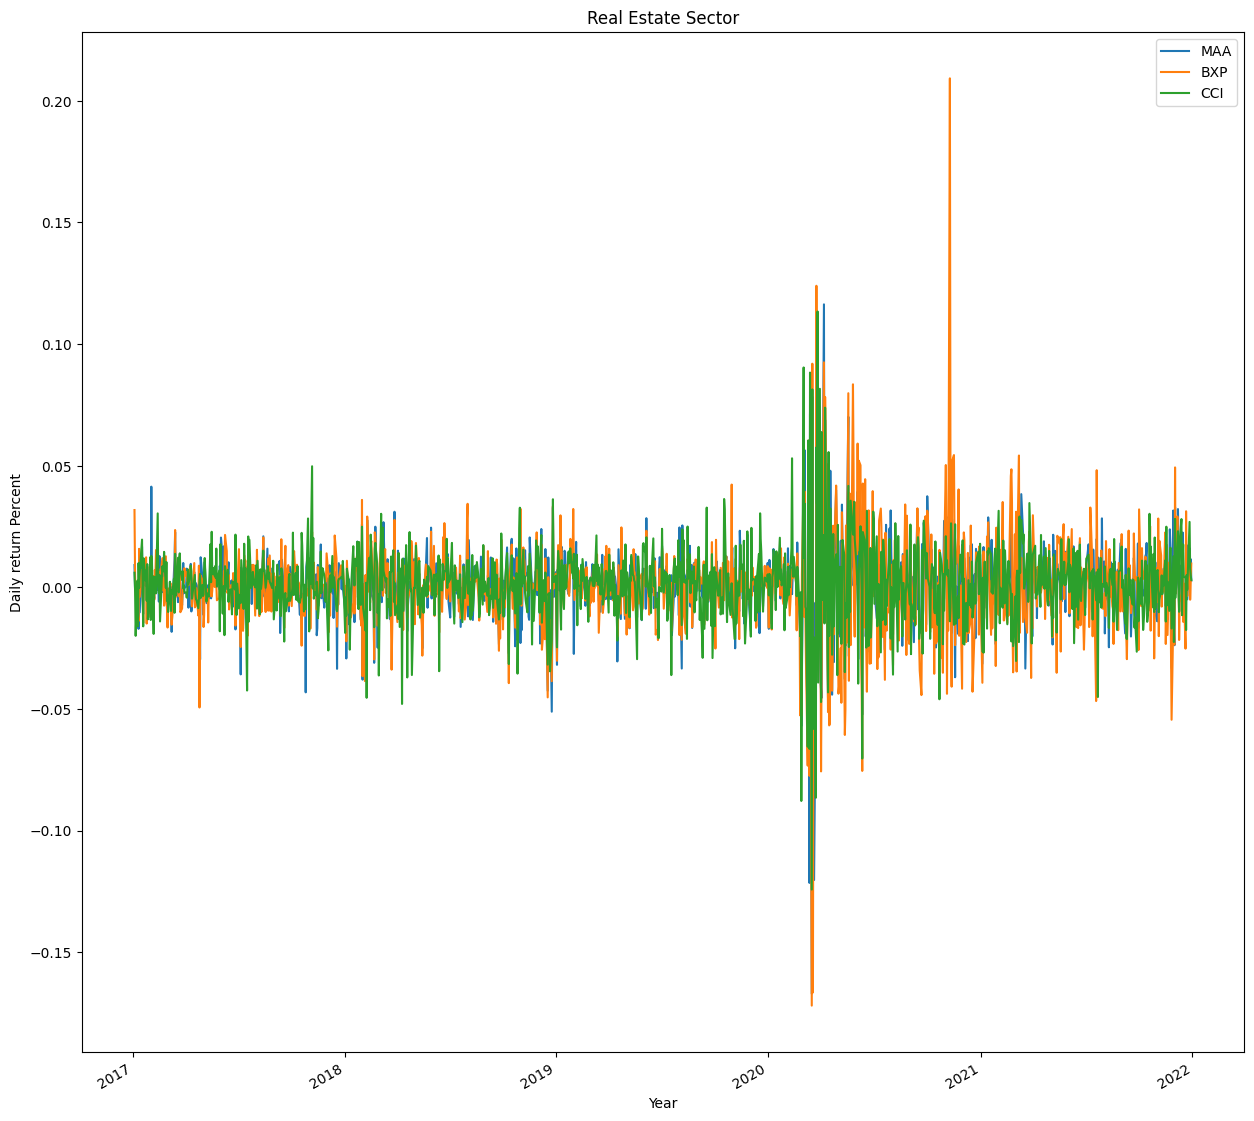

In [ ]:
# Create a line plot of the daily return percentage for three stocks from real estate sector over time
realestate_return_data = return_data.loc[:,['MAA','BXP','CCI']]
realestate_return_data.plot(figsize=(15,15))

plt.xlabel('Year')
plt.ylabel('Daily return Percent')
plt.title('Real Estate Sector')

plt.show()

### 1.2.2 Visualization of Utilities sector

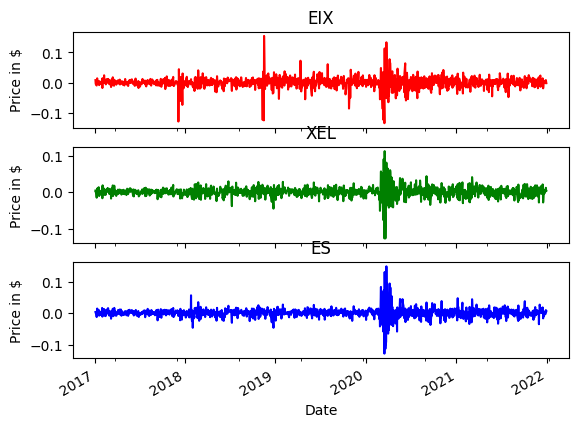

In [ ]:
# Draw subplot showing the historical price data for a different stock, identified by the stock ticker in utilities sector
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

return_data['EIX'].plot(ax=ax1, color='red')
ax1.set_title('EIX')
ax1.set_ylabel('Price in $')

return_data['XEL'].plot(ax=ax2, color='green')
ax2.set_title('XEL')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price in $')

return_data["ES"].plot(ax=ax3, color='blue')
ax3.set_title("ES")
ax3.set_xlabel('Date')
ax3.set_ylabel('Price in $')

plt.show()


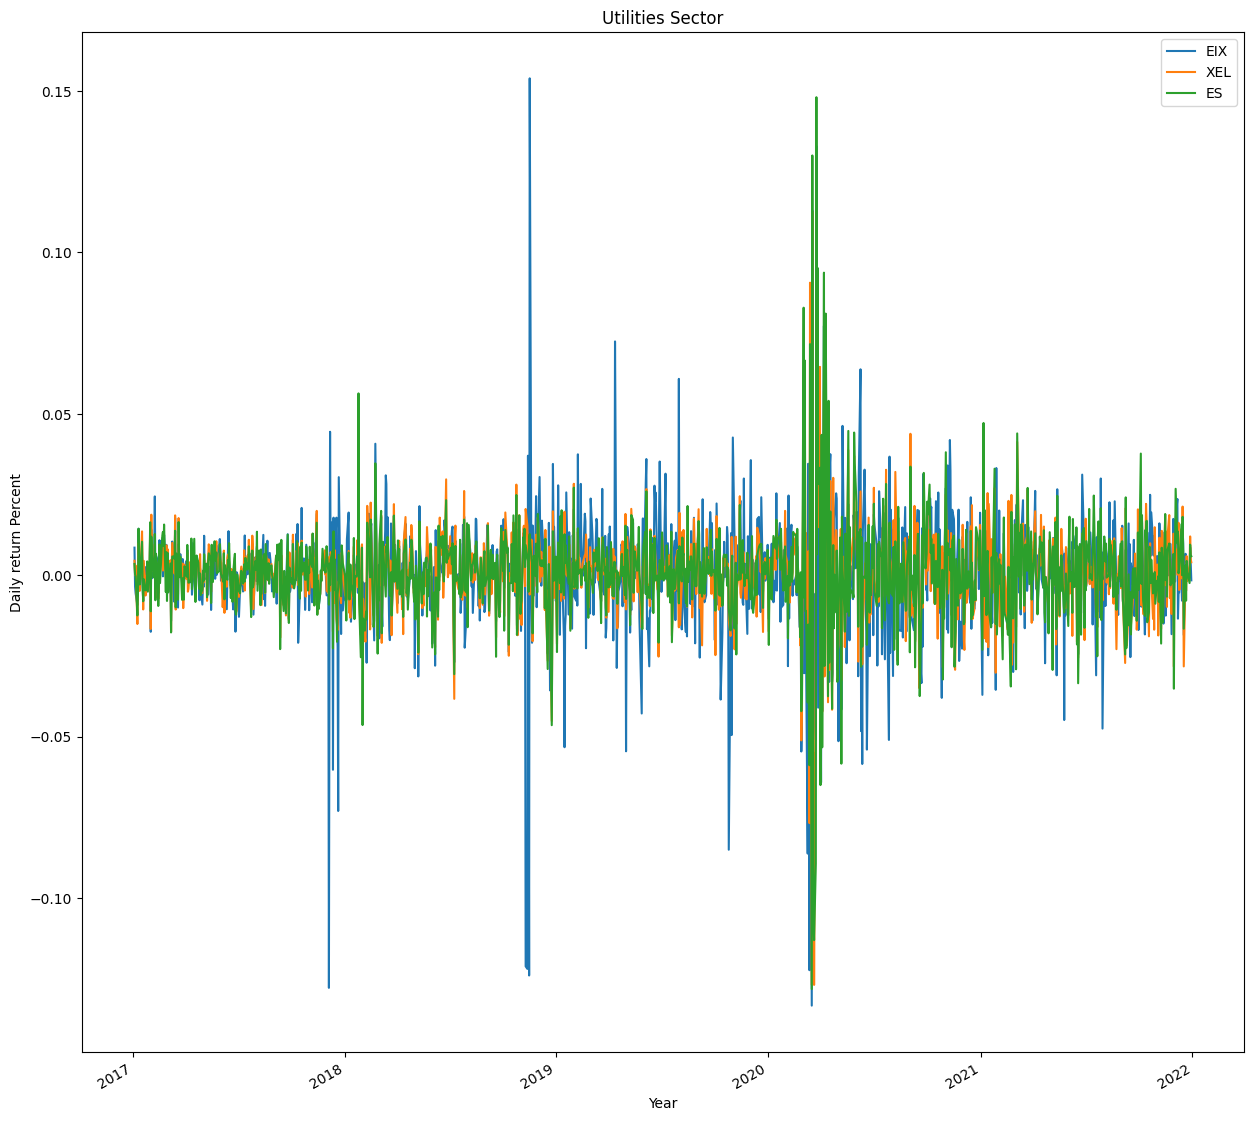

In [ ]:
# Create a line plot of the daily return percentage for three stocks from utilities sector over time
utilities_return_data = return_data.loc[:,['EIX','XEL','ES']]
utilities_return_data.plot(figsize=(15,15))

plt.xlabel('Year')
plt.ylabel('Daily return Percent')
plt.title('Utilities Sector')

plt.show()


### 1.2.3 Visualization of Consumer Staples Sector

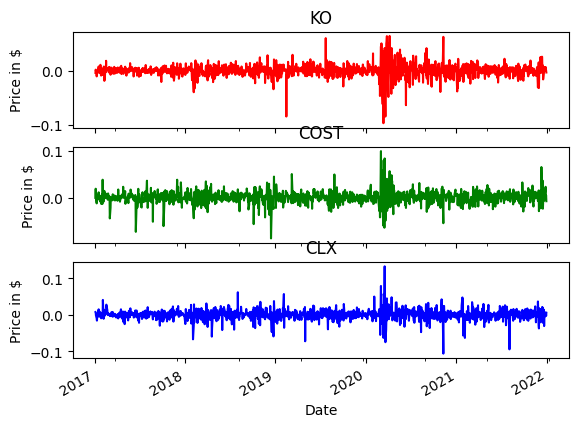

In [ ]:
# Draw subplot showing the historical price data for a different stock, identified by the stock ticker in consumer staples sector
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

return_data['KO'].plot(ax=ax1, color='red')
ax1.set_title('KO')
ax1.set_ylabel('Price in $')

return_data['COST'].plot(ax=ax2, color='green')
ax2.set_title('COST')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price in $')

return_data["CLX"].plot(ax=ax3, color='blue')
ax3.set_title("CLX")
ax3.set_xlabel('Date')
ax3.set_ylabel('Price in $')

plt.show()


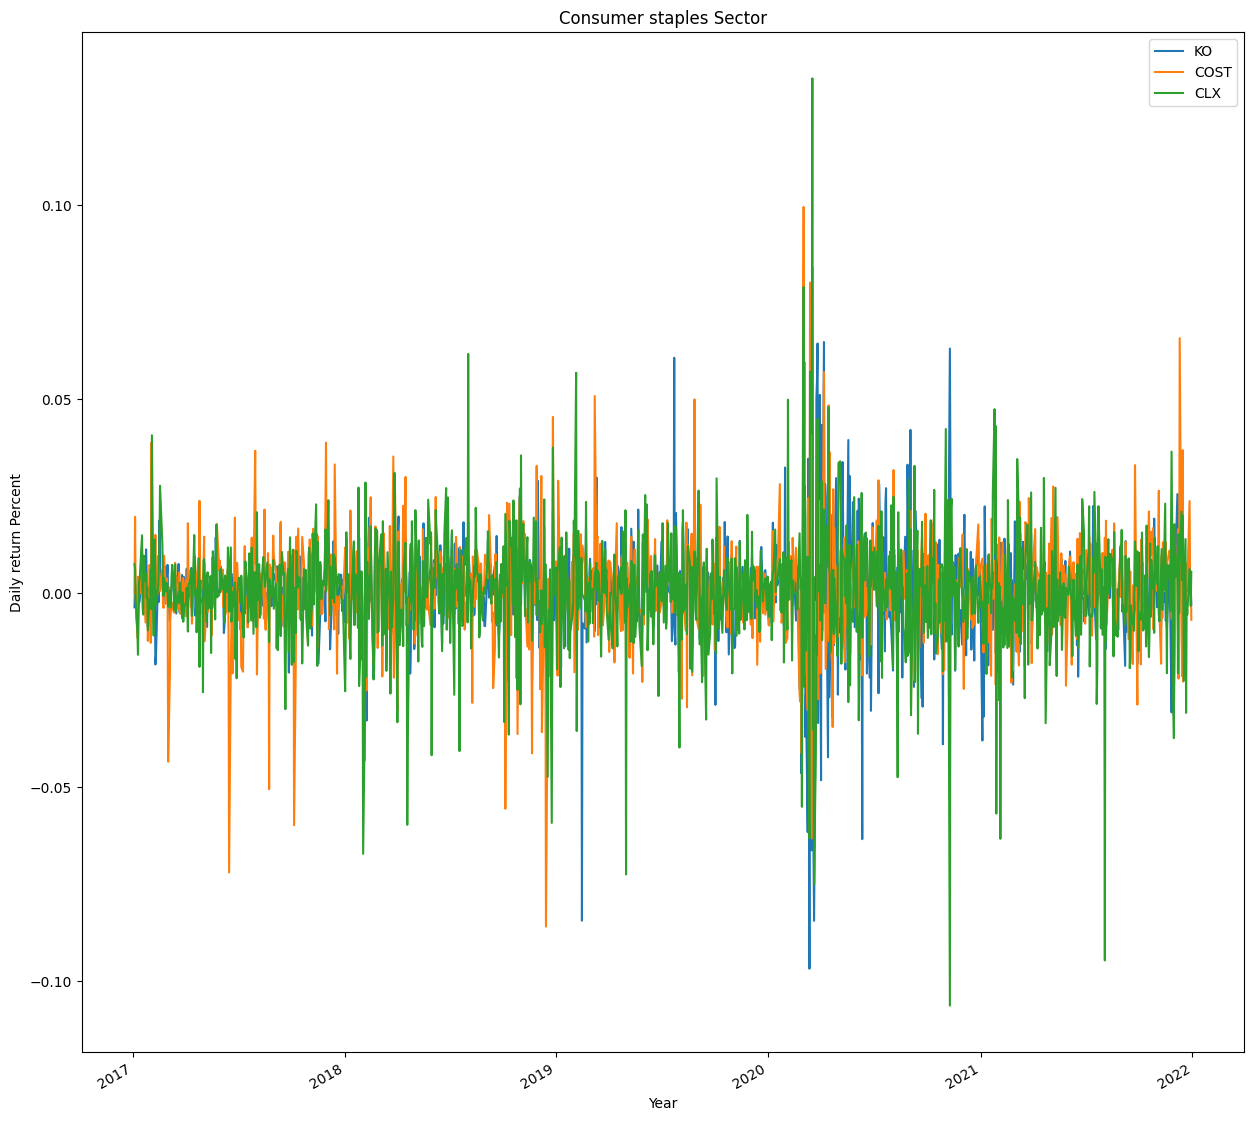

In [ ]:
# Create a line plot of the daily return percentage for three stocks from consumer staples sector over time
consumer_staples_return_data = return_data.loc[:,['KO','COST','CLX']]
consumer_staples_return_data.plot(figsize=(15,15))

plt.xlabel('Year')
plt.ylabel('Daily return Percent')
plt.title('Consumer staples Sector')

plt.show()

## 1.3 - Discussion of the Plots

Real Estate Sector: Three companies from the real estate sector—MAA, BXP, and CCI—have their daily return percentage over time plotted. The plot shows that the daily return percentage for these three stocks has fluctuated over time, with some periods of high volatility and other periods of relative stability. For example, there are periods where all three stocks have a similar trend, such as early 2020 when they all experienced a sharp drop in daily return percentage, likely due to the COVID-19 pandemic. However, there are also periods where the stocks have divergent trends, such as late 2018 when MAA and CCI were experiencing negative returns while BXP was experiencing positive returns.

Utilities Sector: The graph demonstrates how the daily return percentage for each of the three stocks varies throughout time, experiencing both positive and negative returns at different points. With higher daily return fluctuations than the other two equities, the stock EIX appears to have the highest volatility. The returns on the other two equities, XEL and ES, seem to fluctuate less and have more steady returns. The overall performance of the utilities sector on the stock market during the chosen time period is shown by the plot.

Consumer Staple Sector: We can see from the plot that each of the three equities has seen periods of both positive and negative returns. For instance, the daily return % for all three stocks jumps in the first few months of 2020, perhaps as a result of the COVID-19 pandemic's effects on consumer behavior. The three equities have also generally followed a similar path throughout time, but there have been times when one stock has outperformed the others. Overall, the plot offers a helpful visual representation of the daily return percentage for these three equities over the selected time period in the consumer staples sector.

# 2 - Optimization Model



In [ ]:
# install pyomo
!pip install -q pyomo
from pyomo.environ import *

try:
    import google.colab
    try:
        from pyomo.environ import *
    except:
        !pip install -q pyomo
    if not 'ipopt_executable' in vars():
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        ipopt_executable = '/content/ipopt' # THIS IS NEW! We are using the IPOPT Solver.
except:
    pass

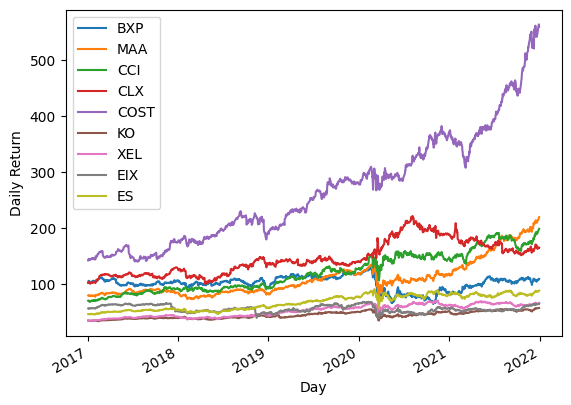

In [ ]:
# Visualization of daily return of all the stocks
prep_data.plot()
plt.xlabel('Day')
plt.ylabel('Daily Return')
plt.show()

In [ ]:
# Mean and Standard Deviation of each stock's return
Avg_Return = pd.DataFrame(np.mean(prep_data) ,columns=["Avg_Return"])
print(Avg_Return)
Std_Dev_Return = pd.DataFrame(np.std(prep_data) ,columns=["Std_Dev_Return"])
print(Std_Dev_Return)

      Avg_Return
BXP   100.596956
MAA   109.464235
CCI   120.506379
CLX   145.384446
COST  265.673440
KO     43.633783
XEL    51.619526
EIX    55.280219
ES     66.604805
      Std_Dev_Return
BXP        12.354148
MAA        32.646602
CCI        34.349685
CLX        29.524887
COST       99.433126
KO          5.914877
XEL        10.566443
EIX         5.833391
ES         13.359627


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
#The covariance matrix representing covariance between stocks
Covariance_matrix = return_data.cov()
Covariance_matrix

,BXP,MAA,CCI,CLX,COST,KO,XEL,EIX,ES
BXP,0.000398,0.000226,0.000140,0.000020,0.000061,0.000147,0.000135,0.000182,0.000145
MAA,0.000226,0.000263,0.000148,0.000062,0.000080,0.000123,0.000150,0.000155,0.000154
CCI,0.000140,0.000148,0.000255,0.000072,0.000087,0.000110,0.000136,0.000131,0.000140
CLX,0.000020,0.000062,0.000072,0.000220,0.000072,0.000054,0.000082,0.000050,0.000086
COST,0.000061,0.000080,0.000087,0.000072,0.000184,0.000070,0.000077,0.000074,0.000083
KO,0.000147,0.000123,0.000110,0.000054,0.000070,0.000161,0.000109,0.000116,0.000115
XEL,0.000135,0.000150,0.000136,0.000082,0.000077,0.000109,0.000201,0.000145,0.000190
EIX,0.000182,0.000155,0.000131,0.000050,0.000074,0.000116,0.000145,0.000370,0.000168
ES,0.000145,0.000154,0.000140,0.000086,0.000083,0.000115,0.000190,0.000168,0.000244


In [ ]:
##The correlation matrix representing correlation between stocks
Corr_matrix = return_data.corr()
Corr_matrix

,BXP,MAA,CCI,CLX,COST,KO,XEL,EIX,ES
BXP,1.000000,0.698375,0.438717,0.067429,0.224447,0.580457,0.475839,0.472875,0.463888
MAA,0.698375,1.000000,0.572788,0.256575,0.362732,0.600660,0.651807,0.496139,0.606151
CCI,0.438717,0.572788,1.000000,0.305011,0.402525,0.545269,0.600095,0.426254,0.562957
CLX,0.067429,0.256575,0.305011,1.000000,0.359137,0.288141,0.391098,0.174372,0.370936
COST,0.224447,0.362732,0.402525,0.359137,1.000000,0.406343,0.402120,0.283380,0.392685
KO,0.580457,0.600660,0.545269,0.288141,0.406343,1.000000,0.608780,0.475444,0.581314
XEL,0.475839,0.651807,0.600095,0.391098,0.402120,0.608780,1.000000,0.530903,0.856284
EIX,0.472875,0.496139,0.426254,0.174372,0.283380,0.475444,0.530903,1.000000,0.557776
ES,0.463888,0.606151,0.562957,0.370936,0.392685,0.581314,0.856284,0.557776,1.000000


In [ ]:
# Create covariance table on stock return dataframe
df_cov = return_data.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # returns a new line

# create the average of each stock
# These coefficients represent the objective function.
df_return = return_data.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
           BXP       MAA       CCI       CLX      COST        KO       XEL  \
BXP   0.000398  0.000226  0.000140  0.000020  0.000061  0.000147  0.000135   
MAA   0.000226  0.000263  0.000148  0.000062  0.000080  0.000123  0.000150   
CCI   0.000140  0.000148  0.000255  0.000072  0.000087  0.000110  0.000136   
CLX   0.000020  0.000062  0.000072  0.000220  0.000072  0.000054  0.000082   
COST  0.000061  0.000080  0.000087  0.000072  0.000184  0.000070  0.000077   
KO    0.000147  0.000123  0.000110  0.000054  0.000070  0.000161  0.000109   
XEL   0.000135  0.000150  0.000136  0.000082  0.000077  0.000109  0.000201   
EIX   0.000182  0.000155  0.000131  0.000050  0.000074  0.000116  0.000145   
ES    0.000145  0.000154  0.000140  0.000086  0.000083  0.000115  0.000190   

           EIX        ES  
BXP   0.000182  0.000145  
MAA   0.000155  0.000154  
CCI   0.000131  0.000140  
CLX   0.000050  0.000086  
COST  0.000074  0.000083  
KO    0.000116  0.000115  
XEL   0.000

# Modern portfolio theory





# **Model Declaration in pyomo**

In [ ]:
from pyomo.environ import *
m = ConcreteModel()

# Defining variables
# Each one is a stock (BXP, MAA, CCI, CLX, COST, KO, XEL, EIX, ES)
# Real Estate Sector(BXP, MAA, CCI)
m.bxp = Var(within=NonNegativeReals, bounds=(0,1))
m.maa = Var(within=NonNegativeReals, bounds=(0,1))
m.cci = Var(within=NonNegativeReals, bounds=(0,1))
# Consumer Staple sector(CLX, COST, KO)
m.clx = Var(within=NonNegativeReals, bounds=(0,1))
m.cost = Var(within=NonNegativeReals, bounds=(0,1))
m.ko = Var(within=NonNegativeReals, bounds=(0,1))
#Utilities sector(XEL, EIX, ES)
m.xel = Var(within=NonNegativeReals, bounds=(0,1))
m.eix = Var(within=NonNegativeReals, bounds=(0,1))
m.es = Var(within=NonNegativeReals, bounds=(0,1))

In [ ]:
# Declare objective
m.objective = Objective(expr =
                        m.bxp*df_return[0] +
                        m.maa*df_return[1] +
                        m.cci*df_return[2] +
                        m.clx*df_return[3] +
                        m.cost*df_return[4] +
                        m.ko*df_return[5] +
                        m.xel*df_return[6] +
                        m.eix*df_return[7] +
                        m.es*df_return[8],
                        sense=maximize)

# Declare constraints
# Sum of all porportions = 1
m.sum_proportions = Constraint(expr = m.bxp + m.maa + m.cci + m.clx + m.cost + m.ko + m.xel + m.eix + m.es == 1)
# Set maximum risk
m.total_risk = Constraint(expr = m.bxp + m.maa + m.cci + m.clx + m.cost + m.ko + m.xel + m.eix + m.es >= 0.0)

Table for calculating risk **bold text**

In [ ]:
# Creating calculations table for calculate the risk
# Calculate risk
def calc_risk(m):
  variables = m.bxp, m.maa, m.cci, m.clx, m.cost, m.ko, m.xel, m.eix, m.es
  tickers_list = ['BXP','MAA','CCI','CLX','COST','KO','XEL','EIX','ES']
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers_list[i],tickers_list[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

# Max risk should be less than 0.01
max_risk = 0.00019
# Sequence of risk levels
risk_limits = np.arange(0.00002, max_risk, 0.000002) # take tiny steps
risk_limits

array([2.00e-05, 2.20e-05, 2.40e-05, 2.60e-05, 2.80e-05, 3.00e-05,
       3.20e-05, 3.40e-05, 3.60e-05, 3.80e-05, 4.00e-05, 4.20e-05,
       4.40e-05, 4.60e-05, 4.80e-05, 5.00e-05, 5.20e-05, 5.40e-05,
       5.60e-05, 5.80e-05, 6.00e-05, 6.20e-05, 6.40e-05, 6.60e-05,
       6.80e-05, 7.00e-05, 7.20e-05, 7.40e-05, 7.60e-05, 7.80e-05,
       8.00e-05, 8.20e-05, 8.40e-05, 8.60e-05, 8.80e-05, 9.00e-05,
       9.20e-05, 9.40e-05, 9.60e-05, 9.80e-05, 1.00e-04, 1.02e-04,
       1.04e-04, 1.06e-04, 1.08e-04, 1.10e-04, 1.12e-04, 1.14e-04,
       1.16e-04, 1.18e-04, 1.20e-04, 1.22e-04, 1.24e-04, 1.26e-04,
       1.28e-04, 1.30e-04, 1.32e-04, 1.34e-04, 1.36e-04, 1.38e-04,
       1.40e-04, 1.42e-04, 1.44e-04, 1.46e-04, 1.48e-04, 1.50e-04,
       1.52e-04, 1.54e-04, 1.56e-04, 1.58e-04, 1.60e-04, 1.62e-04,
       1.64e-04, 1.66e-04, 1.68e-04, 1.70e-04, 1.72e-04, 1.74e-04,
       1.76e-04, 1.78e-04, 1.80e-04, 1.82e-04, 1.84e-04, 1.86e-04,
       1.88e-04, 1.90e-04])

In [ ]:
#print risk limit size
print(risk_limits.size)

86


# Runnig solver for portfolio allocation

In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

# Updating risk contraint for each limit and then solving the problem
parameter_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
#for r in [10]:
for r in risk_limits:
  # Remove constraint to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # Run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition != TerminationCondition.optimal:
    continue

  result = result.write()

  # Store our allocation proportions
  parameter_analysis[r] = [m.bxp(), m.maa(), m.cci(), m.clx(), m.cost(), m.ko(), m.xel(), m.eix(), m.es()]
  # Store our returns
  returns[r] =  m.bxp()*df_return[0] + m.maa()*df_return[1] + m.cci()*df_return[2] + m.clx()*df_return[3] + m.cost()*df_return[4] + m.ko()*df_return[5] + m.xel()*df_return[6] + m.eix()*df_return[7] + m.es()*df_return[8]

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally in

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Solved To Acceptable Level.
  Termination condition: optimal
  Id: 1
  Error rc: 0
  Time: 0.021712303161621094
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
#

# Parametric Analysis

# Plot with allocation of the stocks

# Momentum Trading

In [ ]:
# We may need to restart your runtime
# https://stackoverflow.com/questions/68230237/python-pandas-datareader-and-yahoo-error-remotedataerror-unable-to-read-url
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 70.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime

## 2.2 Plot with allocation of the stocks

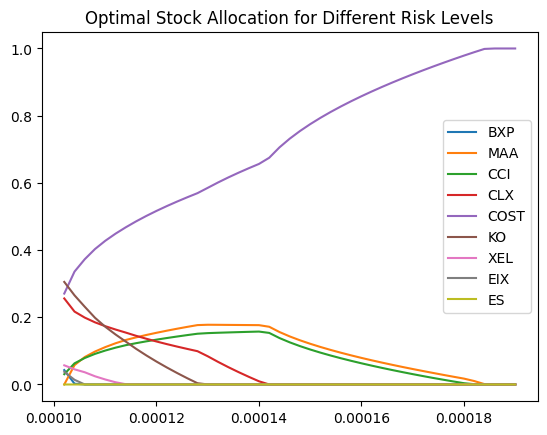

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
parameter_analysis = pd.DataFrame.from_dict(parameter_analysis, orient='index')
parameter_analysis.columns = ['BXP', 'MAA', 'CCI', 'CLX', 'COST', 'KO', 'XEL', 'EIX', 'ES']
parameter_analysis.plot()
#plot the graph
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()
plt.show()

In [ ]:
print(parameter_analysis)

               BXP       MAA       CCI       CLX      COST        KO  \
0.000102  0.042856  0.000000  0.030630  0.256048  0.270566  0.305217   
0.000104  0.002310  0.057623  0.062898  0.216942  0.335901  0.265282   
0.000106  0.000006  0.081649  0.078820  0.199012  0.372825  0.231276   
0.000108  0.000011  0.098001  0.091082  0.184918  0.403097  0.198440   
0.000110  0.000009  0.111199  0.100978  0.173469  0.427607  0.171803   
0.000112  0.000003  0.122607  0.109527  0.163602  0.448760  0.148844   
0.000114  0.000003  0.132409  0.116913  0.154431  0.467733  0.127676   
0.000116  0.000007  0.140120  0.122850  0.144925  0.485284  0.106307   
0.000118  0.000002  0.147263  0.128339  0.136175  0.501474  0.086639   
0.000120  0.000002  0.153842  0.133408  0.127942  0.516587  0.068161   
0.000122  0.000002  0.160021  0.138169  0.120188  0.530806  0.050765   
0.000124  0.000002  0.165872  0.142678  0.112844  0.544271  0.034292   
0.000126  0.000002  0.171440  0.146969  0.105847  0.557092  0.01

In [ ]:
#viewing index
parameter_analysis.columns

Index(['BXP', 'MAA', 'CCI', 'CLX', 'COST', 'KO', 'XEL', 'EIX', 'ES'], dtype='object')

## 2.3 Plot with efficient frontier

In [ ]:
# Create Subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[0.00010200000000000004, 0.00010400000000000005, 0.00010600000000000006, 0.00010800000000000005, 0.00011000000000000004, 0.00011200000000000005, 0.00011400000000000006, 0.00011600000000000005, 0.00011800000000000005, 0.00012000000000000006, 0.00012200000000000007, 0.00012400000000000006, 0.00012600000000000005, 0.00012800000000000008, 0.00013000000000000007, 0.00013200000000000006, 0.00013400000000000006, 0.00013600000000000008, 0.00013800000000000007, 0.00014000000000000007, 0.00014200000000000006, 0.00014400000000000008, 0.00014600000000000008, 0.00014800000000000007, 0.00015000000000000007, 0.00015200000000000006, 0.00015400000000000008, 0.00015600000000000008, 0.00015800000000000007, 0.0001600000000000001, 0.0001620000000000001, 0.00016400000000000008, 0.00016600000000000008, 0.00016800000000000007, 0.0001700000000000001, 0.0001720000000000001, 0.00017400000000000008, 0.0001760000000000001, 0.0001780000000000001, 0.0001800000000000001, 0.0001820000000000001, 0.00018400000000000008,

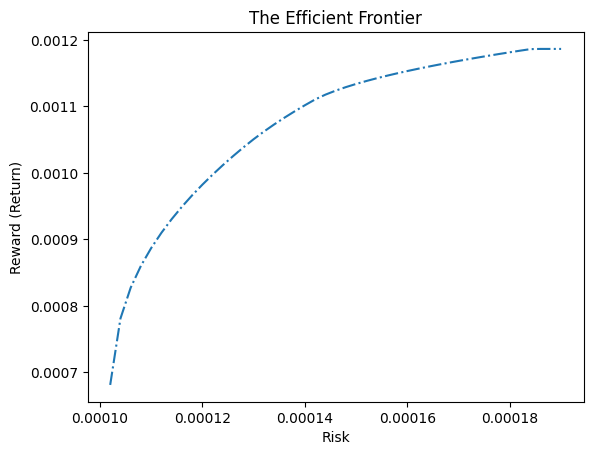

In [ ]:
# Plot Efficient Frontier
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

## 2.4 Portfolio selection

In [ ]:
#Create a new DataFrame containing the top 3 coefficients
allocationDf = parameter_analysis.filter(items=[risk_limits[-1]], axis=0).reset_index().drop(columns=['index']).sort_values(by=0, axis=1, ascending=False).iloc[:,0:3]
allocationDf

,COST,CCI,MAA
0,0.999958,0.000009,0.000009


# 3 - Analyis

## 3.1 - Buy-and-Hold strategy for the MPT portfolio

In [ ]:
ticker = "COST"
gld = si.get_data(ticker,start_date = '01/01/2022',end_date='12/31/2022',interval='1d')
day = np.arange(1, len(gld) + 1) #generate list of trading days
gld['Day'] = day
# Dropping columns we don't want to use
gld.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
gld = gld[['Day', 'open', 'high', 'low', 'close']]
# Renaming the columns
gld.columns = ['Day', 'Open', 'High', 'Low', 'Close']
gld.head()

,Day,Open,High,Low,Close
2022-01-03,1,565.030029,567.469971,555.510010,566.710022
2022-01-04,2,564.229980,568.719971,561.789978,564.229980
2022-01-05,3,563.690002,565.049988,549.770020,549.919983
2022-01-06,4,546.200012,553.520020,543.549988,549.799988
2022-01-07,5,547.549988,548.369995,534.239990,536.179993


In [ ]:
gld.describe()

,Day,Open,High,Low,Close
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,126.000000,510.322151,516.439561,503.965618,510.216016
std,72.601653,37.842832,37.502328,37.779338,37.571862
min,1.000000,420.000000,428.850006,406.510010,416.429993
25%,63.500000,481.764999,489.490005,475.744995,482.504990
50%,126.000000,511.489990,516.000000,501.859985,510.299988
75%,188.500000,534.079987,541.859985,529.235016,533.354980
max,251.000000,607.280029,612.270020,597.729980,608.049988


In [ ]:
# WITH data leakage
# why is it leaking? It includes the 8th day!
#gld['8-day'] = gld['Close'].rolling(8).mean()
#gld['21-day'] = gld['Close'].rolling(21).mean()
#gld.head(n=10)
gld['8-day'] = gld['Close'].rolling(8).mean().shift()
gld['21-day'] = gld['Close'].rolling(21).mean().shift()
gld.dropna(inplace=True)
gld.head(n=10)

,Day,Open,High,Low,Close,8-day,21-day
2022-02-02,22,511.109985,523.989990,510.339996,522.020020,489.973747,511.151427
2022-02-03,23,515.880005,526.440002,514.210022,521.770020,495.025002,509.023331
2022-02-04,24,518.109985,522.000000,510.799988,519.770020,499.133755,507.001429
2022-02-07,25,521.299988,522.000000,514.229980,515.890015,504.440006,505.565716
2022-02-08,26,515.890015,523.390015,510.500000,521.150024,508.492508,503.950955
2022-02-09,27,528.000000,534.239990,525.679993,528.830017,513.321262,503.235243
2022-02-10,28,520.869995,524.469971,514.750000,518.479980,517.871265,503.712863
2022-02-11,29,518.400024,521.349976,507.380005,509.670013,519.540012,503.543813
2022-02-14,30,508.989990,511.529999,501.440002,506.559998,519.697514,502.775719
2022-02-15,31,513.340027,516.000000,510.760010,513.919983,517.765011,502.284290


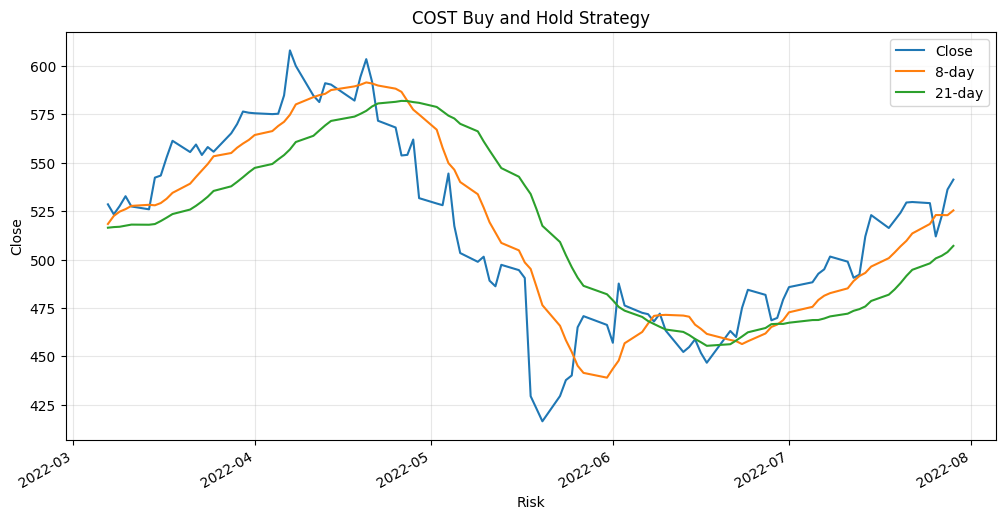

In [ ]:
# Displays first 100 days of trading
gld.iloc[22:123,[4,5,6]].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
title(ticker + " Buy and Hold Strategy")
xlabel("Risk")
ylabel("Close")
plt.show()

In [ ]:
# Difference between current and previous values
gld['logClose'] = np.log(gld['Close']) # price will always be positive, so this operation is well-defined
gld['return'] = gld['logClose'].diff() # the difference will be positive or negative
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return
2022-02-02,22,511.109985,523.989990,510.339996,522.020020,489.973747,511.151427,6.257706,NaN
2022-02-03,23,515.880005,526.440002,514.210022,521.770020,495.025002,509.023331,6.257227,-0.000479
2022-02-04,24,518.109985,522.000000,510.799988,519.770020,499.133755,507.001429,6.253386,-0.003840
2022-02-07,25,521.299988,522.000000,514.229980,515.890015,504.440006,505.565716,6.245894,-0.007493
2022-02-08,26,515.890015,523.390015,510.500000,521.150024,508.492508,503.950955,6.256038,0.010144


In [ ]:
# Converting NaN value to 0
gld.loc["2022-02-02",'return'] = 0.0
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return
2022-02-02,22,511.109985,523.989990,510.339996,522.020020,489.973747,511.151427,6.257706,0.000000
2022-02-03,23,515.880005,526.440002,514.210022,521.770020,495.025002,509.023331,6.257227,-0.000479
2022-02-04,24,518.109985,522.000000,510.799988,519.770020,499.133755,507.001429,6.253386,-0.003840
2022-02-07,25,521.299988,522.000000,514.229980,515.890015,504.440006,505.565716,6.245894,-0.007493
2022-02-08,26,515.890015,523.390015,510.500000,521.150024,508.492508,503.950955,6.256038,0.010144


In [ ]:
# Returns
np.exp(np.sum(gld['return'])) -1

-0.12551246519258719

CCI Stock Buy and Hold Strategy


In [ ]:
ticker = "CCI"
gld = si.get_data(ticker,start_date = '01/01/2022',end_date='12/31/2022',interval='1d')
day = np.arange(1, len(gld) + 1) #generate list of trading days
gld['Day'] = day
# Dropping columns we don't want to use
gld.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
gld = gld[['Day', 'open', 'high', 'low', 'close']]
# Renaming the columns
gld.columns = ['Day', 'Open', 'High', 'Low', 'Close']
gld.head()

,Day,Open,High,Low,Close
2022-01-03,1,209.000000,209.000000,203.779999,207.740005
2022-01-04,2,207.139999,208.250000,201.899994,202.149994
2022-01-05,3,198.750000,198.750000,187.869995,188.460007
2022-01-06,4,189.520004,193.250000,185.250000,192.500000
2022-01-07,5,192.690002,197.229996,191.259995,194.729996


In [ ]:
gld.describe()

,Day,Open,High,Low,Close
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,126.000000,166.740479,168.655378,164.408048,166.488964
std,72.601653,20.630345,20.679417,20.449466,20.652007
min,1.000000,124.309998,126.150002,121.709999,122.449997
25%,63.500000,148.415001,148.834999,143.870003,146.740005
50%,126.000000,173.149994,174.970001,170.410004,173.009995
75%,188.500000,181.575005,182.880005,179.220001,181.529999
max,251.000000,209.000000,209.000000,203.779999,207.740005


In [ ]:
# WITH data leakage
# why is it leaking? It includes the 8th day!
#gld['8-day'] = gld['Close'].rolling(8).mean()
#gld['21-day'] = gld['Close'].rolling(21).mean()
#gld.head(n=10)
gld['8-day'] = gld['Close'].rolling(8).mean().shift()
gld['21-day'] = gld['Close'].rolling(21).mean().shift()
gld.dropna(inplace=True)
gld.head(n=10)

,Day,Open,High,Low,Close,8-day,21-day
2022-02-02,22,181.490005,184.630005,181.089996,184.000000,180.033749,186.376189
2022-02-03,23,182.800003,183.630005,181.389999,181.679993,180.252499,185.245713
2022-02-04,24,179.610001,182.750000,178.500000,180.300003,180.011248,184.270951
2022-02-07,25,180.539993,182.520004,180.039993,180.889999,179.776249,183.882379
2022-02-08,26,180.779999,181.259995,177.250000,177.490005,180.275000,183.329522
2022-02-09,27,179.279999,181.110001,178.570007,179.639999,181.014999,182.508570
2022-02-10,28,177.100006,178.880005,172.440002,173.050003,180.885000,181.983332
2022-02-11,29,173.240005,174.500000,167.669998,168.880005,179.702501,181.290952
2022-02-14,30,169.339996,169.880005,166.300003,167.580002,178.241251,180.312857
2022-02-15,31,169.179993,169.429993,164.899994,165.600006,176.188751,179.369999


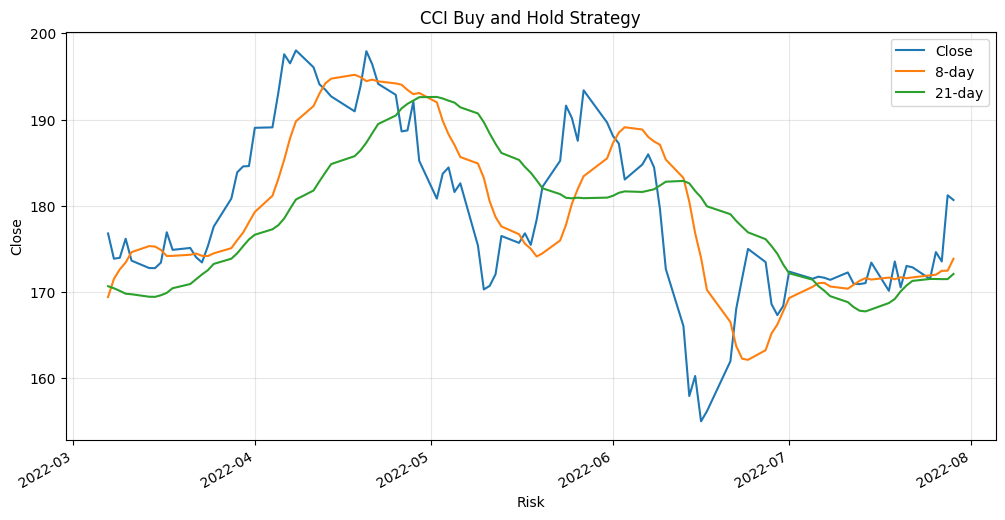

In [ ]:
# Displays first 100 days of trading
gld.iloc[22:123,[4,5,6]].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
title(ticker + " Buy and Hold Strategy")
xlabel("Risk")
ylabel("Close")
plt.show()

In [ ]:
# Difference between current and previous values
gld['logClose'] = np.log(gld['Close']) # price will always be positive, so this operation is well-defined
gld['return'] = gld['logClose'].diff() # the difference will be positive or negative
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return
2022-02-02,22,181.490005,184.630005,181.089996,184.000000,180.033749,186.376189,5.214936,NaN
2022-02-03,23,182.800003,183.630005,181.389999,181.679993,180.252499,185.245713,5.202247,-0.012689
2022-02-04,24,179.610001,182.750000,178.500000,180.300003,180.011248,184.270951,5.194622,-0.007625
2022-02-07,25,180.539993,182.520004,180.039993,180.889999,179.776249,183.882379,5.197889,0.003267
2022-02-08,26,180.779999,181.259995,177.250000,177.490005,180.275000,183.329522,5.178914,-0.018975


In [ ]:
# Converting NaN value to 0
gld.loc["2022-02-02",'return'] = 0.0
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return
2022-02-02,22,181.490005,184.630005,181.089996,184.000000,180.033749,186.376189,5.214936,0.000000
2022-02-03,23,182.800003,183.630005,181.389999,181.679993,180.252499,185.245713,5.202247,-0.012689
2022-02-04,24,179.610001,182.750000,178.500000,180.300003,180.011248,184.270951,5.194622,-0.007625
2022-02-07,25,180.539993,182.520004,180.039993,180.889999,179.776249,183.882379,5.197889,0.003267
2022-02-08,26,180.779999,181.259995,177.250000,177.490005,180.275000,183.329522,5.178914,-0.018975


In [ ]:
# Returns
np.exp(np.sum(gld['return'])) -1

-0.2628260902736502

MAA Stock Buy and Hold Strategy

In [ ]:
ticker = "MAA"
gld = si.get_data(ticker,start_date = '01/01/2022',end_date='12/31/2022',interval='1d')
day = np.arange(1, len(gld) + 1) #generate list of trading days
gld['Day'] = day
# Dropping columns we don't want to use
gld.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
gld = gld[['Day', 'open', 'high', 'low', 'close']]
# Renaming the columns
gld.columns = ['Day', 'Open', 'High', 'Low', 'Close']
gld.head()

,Day,Open,High,Low,Close
2022-01-03,1,229.429993,230.710007,222.750000,226.130005
2022-01-04,2,227.020004,230.410004,226.520004,227.389999
2022-01-05,3,226.830002,227.960007,223.149994,223.220001
2022-01-06,4,223.639999,224.410004,219.800003,220.899994
2022-01-07,5,219.889999,220.039993,216.100006,216.419998


In [ ]:
gld.describe()

,Day,Open,High,Low,Close
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,126.000000,180.963068,182.900199,178.578486,180.653546
std,72.601653,22.465506,22.611711,22.093543,22.313378
min,1.000000,141.500000,146.529999,141.130005,142.339996
25%,63.500000,161.299995,163.639999,159.204994,161.390007
50%,126.000000,175.380005,178.080002,173.779999,175.449997
75%,188.500000,205.550003,207.595001,202.875000,205.144997
max,251.000000,229.429993,230.710007,226.520004,227.389999


In [ ]:
# WITH data leakage
# why is it leaking? It includes the 8th day!
#gld['8-day'] = gld['Close'].rolling(8).mean()
#gld['21-day'] = gld['Close'].rolling(21).mean()
#gld.head(n=10)
gld['8-day'] = gld['Close'].rolling(8).mean().shift()
gld['21-day'] = gld['Close'].rolling(21).mean().shift()
gld.dropna(inplace=True)
gld.head(n=10)

,Day,Open,High,Low,Close,8-day,21-day
2022-02-02,22,205.979996,214.720001,205.210007,212.029999,202.084999,211.287619
2022-02-03,23,211.990005,215.929993,208.350006,213.020004,203.227499,210.616190
2022-02-04,24,211.470001,215.940002,209.350006,212.529999,204.504999,209.931904
2022-02-07,25,213.070007,214.869995,209.820007,210.330002,206.172499,209.422857
2022-02-08,26,209.960007,211.649994,208.240005,209.610001,207.589998,208.919524
2022-02-09,27,212.759995,217.220001,212.759995,216.539993,209.276249,208.595238
2022-02-10,28,212.880005,215.809998,210.479996,211.500000,210.748749,208.682857
2022-02-11,29,211.229996,214.660004,209.330002,210.830002,211.351250,208.583809
2022-02-14,30,209.990005,212.490005,206.740005,207.580002,212.048750,208.302857
2022-02-15,31,208.910004,210.509995,207.589996,208.350006,211.492500,207.763333


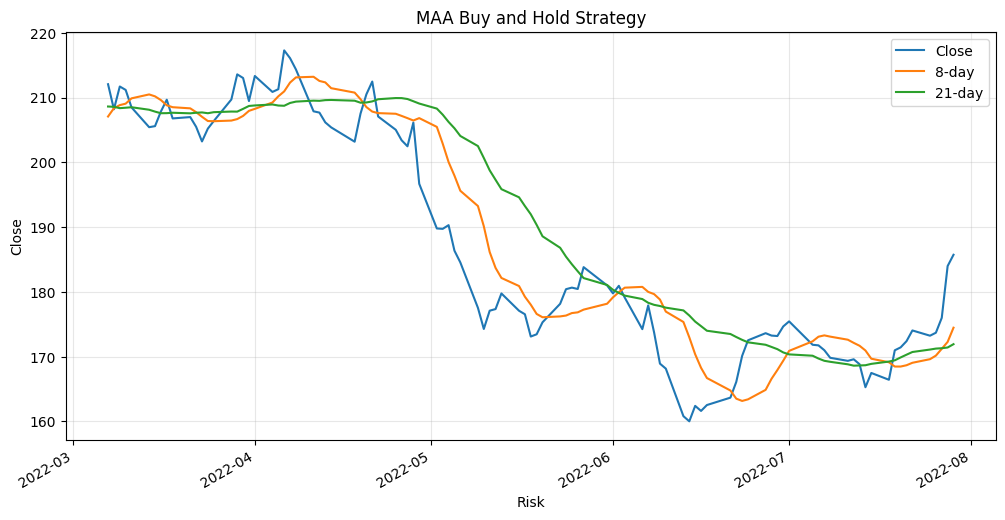

In [ ]:
# Displays first 100 days of trading
gld.iloc[22:123,[4,5,6]].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
title(ticker + " Buy and Hold Strategy")
xlabel("Risk")
ylabel("Close")
plt.show()

In [ ]:
# Difference between current and previous values
gld['logClose'] = np.log(gld['Close']) # price will always be positive, so this operation is well-defined
gld['return'] = gld['logClose'].diff() # the difference will be positive or negative
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return
2022-02-02,22,205.979996,214.720001,205.210007,212.029999,202.084999,211.287619,5.356728,NaN
2022-02-03,23,211.990005,215.929993,208.350006,213.020004,203.227499,210.616190,5.361386,0.004658
2022-02-04,24,211.470001,215.940002,209.350006,212.529999,204.504999,209.931904,5.359083,-0.002303
2022-02-07,25,213.070007,214.869995,209.820007,210.330002,206.172499,209.422857,5.348678,-0.010405
2022-02-08,26,209.960007,211.649994,208.240005,209.610001,207.589998,208.919524,5.345249,-0.003429


In [ ]:
# Converting NaN value to 0
gld.loc["2022-02-02",'return'] = 0.0
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return
2022-02-02,22,205.979996,214.720001,205.210007,212.029999,202.084999,211.287619,5.356728,0.000000
2022-02-03,23,211.990005,215.929993,208.350006,213.020004,203.227499,210.616190,5.361386,0.004658
2022-02-04,24,211.470001,215.940002,209.350006,212.529999,204.504999,209.931904,5.359083,-0.002303
2022-02-07,25,213.070007,214.869995,209.820007,210.330002,206.172499,209.422857,5.348678,-0.010405
2022-02-08,26,209.960007,211.649994,208.240005,209.610001,207.589998,208.919524,5.345249,-0.003429


In [ ]:
# Returns
np.exp(np.sum(gld['return'])) -1

-0.2595858774843658

## 3.2 - Momentum trading strategy for each stock in the MPT portfolio

In [ ]:
ticker = "COST"
gld = si.get_data(ticker,start_date = '01/01/2022',end_date='12/31/2022',interval='1d')
day = np.arange(1, len(gld) + 1) #generate list of trading days
gld['Day'] = day
# Dropping columns we don't want to use
gld.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
gld = gld[['Day', 'open', 'high', 'low', 'close']]
# Renaming the columns
gld.columns = ['Day', 'Open', 'High', 'Low', 'Close']
gld.head()

,Day,Open,High,Low,Close
2022-01-03,1,565.030029,567.469971,555.510010,566.710022
2022-01-04,2,564.229980,568.719971,561.789978,564.229980
2022-01-05,3,563.690002,565.049988,549.770020,549.919983
2022-01-06,4,546.200012,553.520020,543.549988,549.799988
2022-01-07,5,547.549988,548.369995,534.239990,536.179993


In [ ]:
# WITH data leakage
# why is it leaking? It includes the 8th day!
#gld['8-day'] = gld['Close'].rolling(8).mean()
#gld['21-day'] = gld['Close'].rolling(21).mean()
#gld.head(n=10)
gld['8-day'] = gld['Close'].rolling(8).mean().shift()
gld['21-day'] = gld['Close'].rolling(21).mean().shift()
gld.dropna(inplace=True)
gld.head(n=10)

,Day,Open,High,Low,Close,8-day,21-day
2022-02-02,22,511.109985,523.989990,510.339996,522.020020,489.973747,511.151427
2022-02-03,23,515.880005,526.440002,514.210022,521.770020,495.025002,509.023331
2022-02-04,24,518.109985,522.000000,510.799988,519.770020,499.133755,507.001429
2022-02-07,25,521.299988,522.000000,514.229980,515.890015,504.440006,505.565716
2022-02-08,26,515.890015,523.390015,510.500000,521.150024,508.492508,503.950955
2022-02-09,27,528.000000,534.239990,525.679993,528.830017,513.321262,503.235243
2022-02-10,28,520.869995,524.469971,514.750000,518.479980,517.871265,503.712863
2022-02-11,29,518.400024,521.349976,507.380005,509.670013,519.540012,503.543813
2022-02-14,30,508.989990,511.529999,501.440002,506.559998,519.697514,502.775719
2022-02-15,31,513.340027,516.000000,510.760010,513.919983,517.765011,502.284290


In [ ]:
# Difference between current and previous values
gld['logClose'] = np.log(gld['Close']) # price will always be positive, so this operation is well-defined
gld['return'] = gld['logClose'].diff() # the difference will be positive or negative
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return
2022-02-02,22,511.109985,523.989990,510.339996,522.020020,489.973747,511.151427,6.257706,NaN
2022-02-03,23,515.880005,526.440002,514.210022,521.770020,495.025002,509.023331,6.257227,-0.000479
2022-02-04,24,518.109985,522.000000,510.799988,519.770020,499.133755,507.001429,6.253386,-0.003840
2022-02-07,25,521.299988,522.000000,514.229980,515.890015,504.440006,505.565716,6.245894,-0.007493
2022-02-08,26,515.890015,523.390015,510.500000,521.150024,508.492508,503.950955,6.256038,0.010144


In [ ]:
# Adding the invested column
gld['invested'] = np.where(gld['8-day'] > gld['21-day'], 1, 0) # 8 - 21
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested
2022-02-02,22,511.109985,523.989990,510.339996,522.020020,489.973747,511.151427,6.257706,NaN,0
2022-02-03,23,515.880005,526.440002,514.210022,521.770020,495.025002,509.023331,6.257227,-0.000479,0
2022-02-04,24,518.109985,522.000000,510.799988,519.770020,499.133755,507.001429,6.253386,-0.003840,0
2022-02-07,25,521.299988,522.000000,514.229980,515.890015,504.440006,505.565716,6.245894,-0.007493,0
2022-02-08,26,515.890015,523.390015,510.500000,521.150024,508.492508,503.950955,6.256038,0.010144,1


In [ ]:
print(gld['invested'].value_counts())

1    129
0    101
Name: invested, dtype: int64


In [ ]:
# Making Red and Green triankgle signals
gld['signal'] = gld['invested'].diff()
print(gld['signal'].value_counts())

 0.0    219
 1.0      5
-1.0      5
Name: signal, dtype: int64


In [ ]:
gld.loc["2022-01-03",'signal'] = 1.0
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested,signal
2022-02-02,22.0,511.109985,523.989990,510.339996,522.020020,489.973747,511.151427,6.257706,NaN,0.0,NaN
2022-02-03,23.0,515.880005,526.440002,514.210022,521.770020,495.025002,509.023331,6.257227,-0.000479,0.0,0.0
2022-02-04,24.0,518.109985,522.000000,510.799988,519.770020,499.133755,507.001429,6.253386,-0.003840,0.0,0.0
2022-02-07,25.0,521.299988,522.000000,514.229980,515.890015,504.440006,505.565716,6.245894,-0.007493,0.0,0.0
2022-02-08,26.0,515.890015,523.390015,510.500000,521.150024,508.492508,503.950955,6.256038,0.010144,1.0,1.0


In [ ]:
# Displays the Trading Days
gld[gld['signal'].isin([1,-1])]

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested,signal
2022-02-08,26.0,515.890015,523.390015,510.500000,521.150024,508.492508,503.950955,6.256038,0.010144,1.0,1.0
2022-02-25,38.0,508.579987,518.250000,505.250000,517.489990,507.947498,509.196195,6.248990,0.023284,0.0,-1.0
2022-03-07,44.0,523.450012,545.289978,523.419983,528.520020,518.382496,516.445716,6.270081,0.005730,1.0,1.0
2022-04-28,81.0,555.469971,564.799988,545.799988,562.000000,577.430008,581.340474,6.331502,0.014193,0.0,-1.0
2022-06-08,109.0,471.779999,474.429993,466.890015,467.989990,470.883747,466.711900,6.148447,-0.008066,1.0,1.0
2022-06-22,118.0,459.390015,464.720001,458.500000,459.959991,457.844997,458.169044,6.131140,-0.006825,0.0,-1.0
2022-06-30,124.0,468.299988,482.089996,464.720001,479.279999,468.666245,466.742853,6.172285,0.019893,1.0,1.0
2022-08-31,167.0,525.539978,526.320007,520.260010,522.099976,540.385002,542.880961,6.257859,-0.003900,0.0,-1.0
2022-10-27,207.0,499.809998,503.010010,494.140015,496.540009,480.893749,476.612380,6.207664,-0.005843,1.0,1.0
2022-12-07,235.0,479.089996,486.540009,478.869995,481.970001,512.624996,514.092375,6.177882,0.001682,0.0,-1.0


In [ ]:
# Shows how much money is made
gld['system_return'] = gld['invested'] * gld['return']
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested,signal,system_return
2022-02-02,22.0,511.109985,523.989990,510.339996,522.020020,489.973747,511.151427,6.257706,NaN,0.0,NaN,NaN
2022-02-03,23.0,515.880005,526.440002,514.210022,521.770020,495.025002,509.023331,6.257227,-0.000479,0.0,0.0,-0.000000
2022-02-04,24.0,518.109985,522.000000,510.799988,519.770020,499.133755,507.001429,6.253386,-0.003840,0.0,0.0,-0.000000
2022-02-07,25.0,521.299988,522.000000,514.229980,515.890015,504.440006,505.565716,6.245894,-0.007493,0.0,0.0,-0.000000
2022-02-08,26.0,515.890015,523.390015,510.500000,521.150024,508.492508,503.950955,6.256038,0.010144,1.0,1.0,0.010144


In [ ]:
np.exp(np.sum(gld['system_return'])) -1

0.09011411508027356

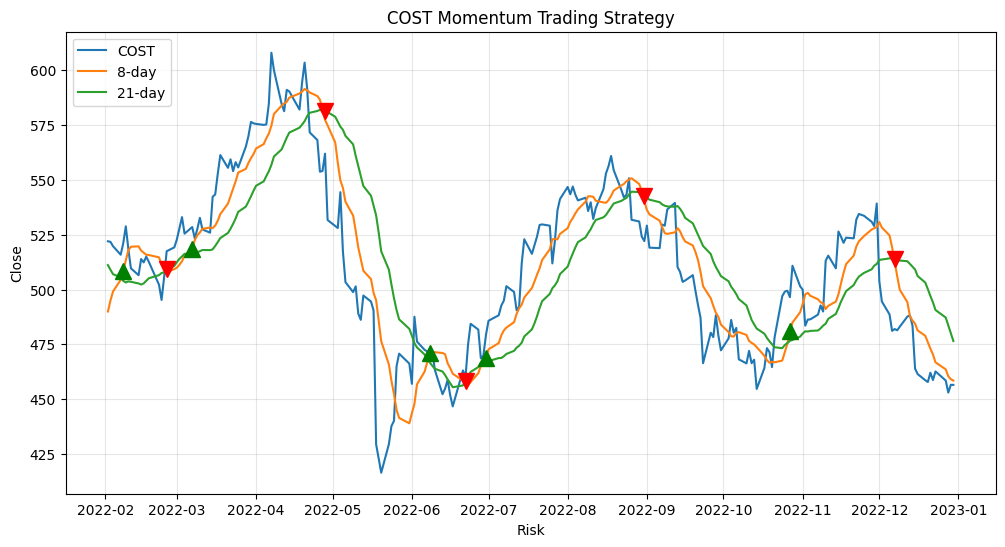

In [ ]:
# Shows last years Trading
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
title(ticker + " Momentum Trading Strategy")
xlabel("Risk")
ylabel("Close")
plt.plot(gld.iloc[-252:]['Close'], label = 'COST') # actual value
plt.plot(gld.iloc[-252:]['8-day'], label = '8-day') # 8-day average
plt.plot(gld.iloc[-252:]['21-day'], label = '21-day') # 21-day average
plt.plot(gld[-252:].loc[gld.signal == 1].index, gld[-252:]['8-day'][gld.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-252:].loc[gld.signal == -1].index, gld[-252:]['21-day'][gld.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

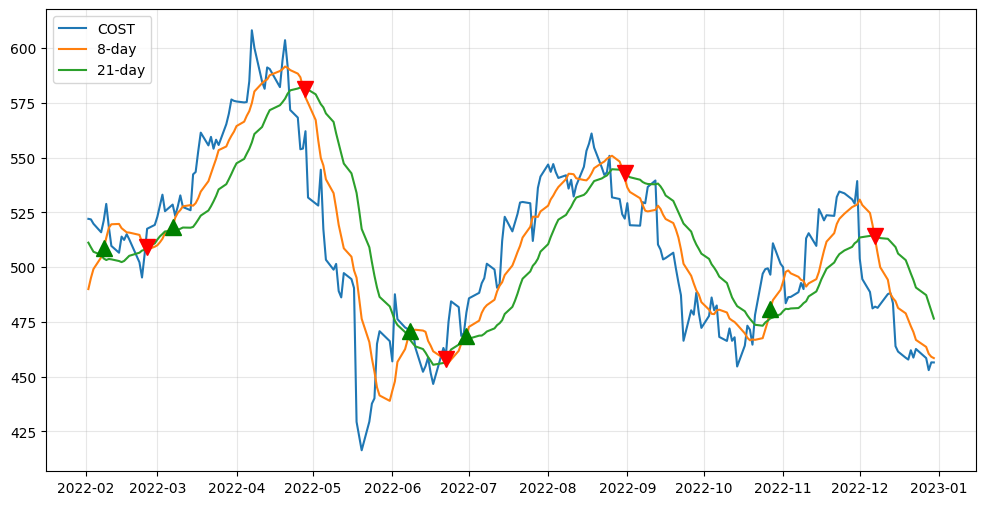

In [ ]:
# Displays all time Trading Strategy
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[:]['Close'], label = 'COST')
plt.plot(gld.iloc[:]['8-day'], label = '8-day')
plt.plot(gld.iloc[:]['21-day'], label = '21-day')
plt.plot(gld[:].loc[gld.signal == 1].index, gld[:]['8-day'][gld.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(gld[:].loc[gld.signal == -1].index, gld[:]['21-day'][gld.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

CCI Momentum Trading

In [ ]:
ticker = "CCI"
gld = si.get_data(ticker,start_date = '01/01/2022',end_date='12/31/2022',interval='1d')
day = np.arange(1, len(gld) + 1) #generate list of trading days
gld['Day'] = day
# Dropping columns we don't want to use
gld.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
gld = gld[['Day', 'open', 'high', 'low', 'close']]
# Renaming the columns
gld.columns = ['Day', 'Open', 'High', 'Low', 'Close']
gld.head()

,Day,Open,High,Low,Close
2022-01-03,1,209.000000,209.000000,203.779999,207.740005
2022-01-04,2,207.139999,208.250000,201.899994,202.149994
2022-01-05,3,198.750000,198.750000,187.869995,188.460007
2022-01-06,4,189.520004,193.250000,185.250000,192.500000
2022-01-07,5,192.690002,197.229996,191.259995,194.729996


In [ ]:
# Data leakage
#gld['8-day'] = gld['Close'].rolling(8).mean()
#gld['21-day'] = gld['Close'].rolling(21).mean()
#gld.head(n=10)
gld['8-day'] = gld['Close'].rolling(8).mean().shift()
gld['21-day'] = gld['Close'].rolling(21).mean().shift()
gld.dropna(inplace=True)
gld.head(n=10)

,Day,Open,High,Low,Close,8-day,21-day
2022-02-02,22,181.490005,184.630005,181.089996,184.000000,180.033749,186.376189
2022-02-03,23,182.800003,183.630005,181.389999,181.679993,180.252499,185.245713
2022-02-04,24,179.610001,182.750000,178.500000,180.300003,180.011248,184.270951
2022-02-07,25,180.539993,182.520004,180.039993,180.889999,179.776249,183.882379
2022-02-08,26,180.779999,181.259995,177.250000,177.490005,180.275000,183.329522
2022-02-09,27,179.279999,181.110001,178.570007,179.639999,181.014999,182.508570
2022-02-10,28,177.100006,178.880005,172.440002,173.050003,180.885000,181.983332
2022-02-11,29,173.240005,174.500000,167.669998,168.880005,179.702501,181.290952
2022-02-14,30,169.339996,169.880005,166.300003,167.580002,178.241251,180.312857
2022-02-15,31,169.179993,169.429993,164.899994,165.600006,176.188751,179.369999


In [ ]:
# Difference between current and previous values
gld['logClose'] = np.log(gld['Close']) # price will always be positive, so this operation is well-defined
gld['return'] = gld['logClose'].diff() # the difference will be positive or negative
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return
2022-02-02,22,181.490005,184.630005,181.089996,184.000000,180.033749,186.376189,5.214936,NaN
2022-02-03,23,182.800003,183.630005,181.389999,181.679993,180.252499,185.245713,5.202247,-0.012689
2022-02-04,24,179.610001,182.750000,178.500000,180.300003,180.011248,184.270951,5.194622,-0.007625
2022-02-07,25,180.539993,182.520004,180.039993,180.889999,179.776249,183.882379,5.197889,0.003267
2022-02-08,26,180.779999,181.259995,177.250000,177.490005,180.275000,183.329522,5.178914,-0.018975


In [ ]:
# Adding the invested column
gld['invested'] = np.where(gld['8-day'] > gld['21-day'], 1, 0) # 8 - 21
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested
2022-02-02,22,181.490005,184.630005,181.089996,184.000000,180.033749,186.376189,5.214936,NaN,0
2022-02-03,23,182.800003,183.630005,181.389999,181.679993,180.252499,185.245713,5.202247,-0.012689,0
2022-02-04,24,179.610001,182.750000,178.500000,180.300003,180.011248,184.270951,5.194622,-0.007625,0
2022-02-07,25,180.539993,182.520004,180.039993,180.889999,179.776249,183.882379,5.197889,0.003267,0
2022-02-08,26,180.779999,181.259995,177.250000,177.490005,180.275000,183.329522,5.178914,-0.018975,0


In [ ]:
print(gld['invested'].value_counts())

1    117
0    113
Name: invested, dtype: int64


In [ ]:
# Making Red and Green triankgle signals
gld['signal'] = gld['invested'].diff()
print(gld['signal'].value_counts())

 0.0    221
 1.0      4
-1.0      4
Name: signal, dtype: int64


In [ ]:
gld.loc["2022-01-03",'signal'] = 1.0
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested,signal
2022-02-02,22.0,181.490005,184.630005,181.089996,184.000000,180.033749,186.376189,5.214936,NaN,0.0,NaN
2022-02-03,23.0,182.800003,183.630005,181.389999,181.679993,180.252499,185.245713,5.202247,-0.012689,0.0,0.0
2022-02-04,24.0,179.610001,182.750000,178.500000,180.300003,180.011248,184.270951,5.194622,-0.007625,0.0,0.0
2022-02-07,25.0,180.539993,182.520004,180.039993,180.889999,179.776249,183.882379,5.197889,0.003267,0.0,0.0
2022-02-08,26.0,180.779999,181.259995,177.250000,177.490005,180.275000,183.329522,5.178914,-0.018975,0.0,0.0


In [ ]:
# Displays the Trading Days
gld[gld['signal'].isin([1,-1])]

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested,signal
2022-03-08,45.0,175.809998,179.300003,173.830002,173.850006,171.512499,170.428095,5.158193,-0.016713,1.0,1.0
2022-05-02,83.0,186.460007,186.740005,177.589996,180.820007,191.997499,192.620952,5.197502,-0.023988,0.0,-1.0
2022-05-26,101.0,191.000000,191.809998,186.410004,187.529999,181.941252,180.934288,5.233939,-0.014032,1.0,1.0
2022-06-14,113.0,164.500000,165.110001,157.190002,157.919998,180.469999,182.592381,5.062089,-0.050140,0.0,-1.0
2022-07-06,127.0,172.789993,174.720001,171.539993,171.770004,171.025002,170.670953,5.146156,0.001398,1.0,1.0
2022-08-26,164.0,177.339996,177.979996,173.289993,173.410004,178.417500,179.422858,5.155659,-0.022861,0.0,-1.0
2022-11-07,214.0,130.610001,131.179993,129.110001,129.839996,130.317499,129.817619,4.866303,-0.001616,1.0,1.0
2022-12-20,244.0,132.419998,134.429993,131.309998,133.809998,138.523752,138.957620,4.896421,0.004494,0.0,-1.0
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
# Shows how much money is made
gld['system_return'] = gld['invested'] * gld['return']
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested,signal,system_return
2022-02-02,22.0,181.490005,184.630005,181.089996,184.000000,180.033749,186.376189,5.214936,NaN,0.0,NaN,NaN
2022-02-03,23.0,182.800003,183.630005,181.389999,181.679993,180.252499,185.245713,5.202247,-0.012689,0.0,0.0,-0.0
2022-02-04,24.0,179.610001,182.750000,178.500000,180.300003,180.011248,184.270951,5.194622,-0.007625,0.0,0.0,-0.0
2022-02-07,25.0,180.539993,182.520004,180.039993,180.889999,179.776249,183.882379,5.197889,0.003267,0.0,0.0,0.0
2022-02-08,26.0,180.779999,181.259995,177.250000,177.490005,180.275000,183.329522,5.178914,-0.018975,0.0,0.0,-0.0


In [ ]:
np.exp(np.sum(gld['system_return'])) -1

-0.030900942721392655

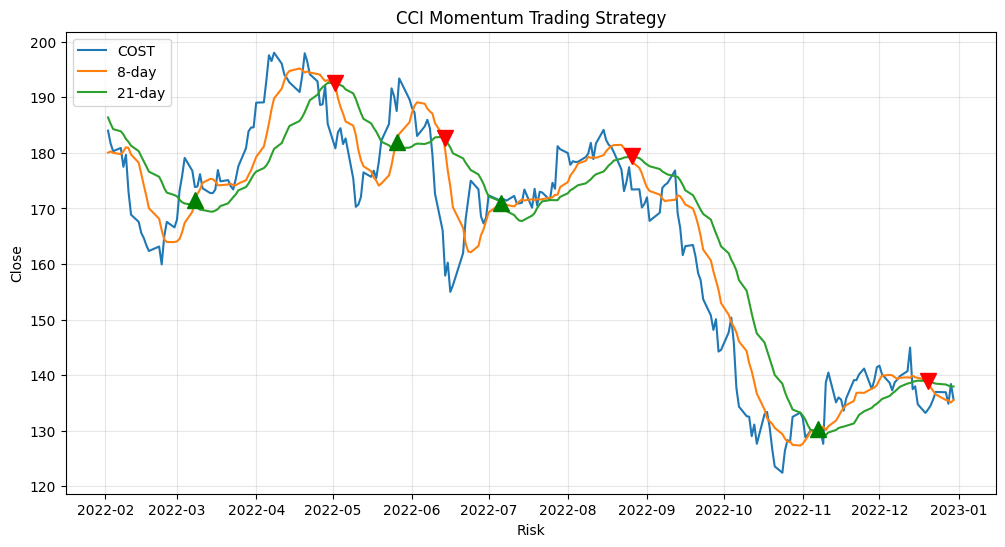

In [ ]:
# Shows last years Trading
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
title(ticker + " Momentum Trading Strategy")
xlabel("Risk")
ylabel("Close")
plt.plot(gld.iloc[-252:]['Close'], label = 'COST') # actual value
plt.plot(gld.iloc[-252:]['8-day'], label = '8-day') # 8-day average
plt.plot(gld.iloc[-252:]['21-day'], label = '21-day') # 21-day average
plt.plot(gld[-252:].loc[gld.signal == 1].index, gld[-252:]['8-day'][gld.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-252:].loc[gld.signal == -1].index, gld[-252:]['21-day'][gld.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

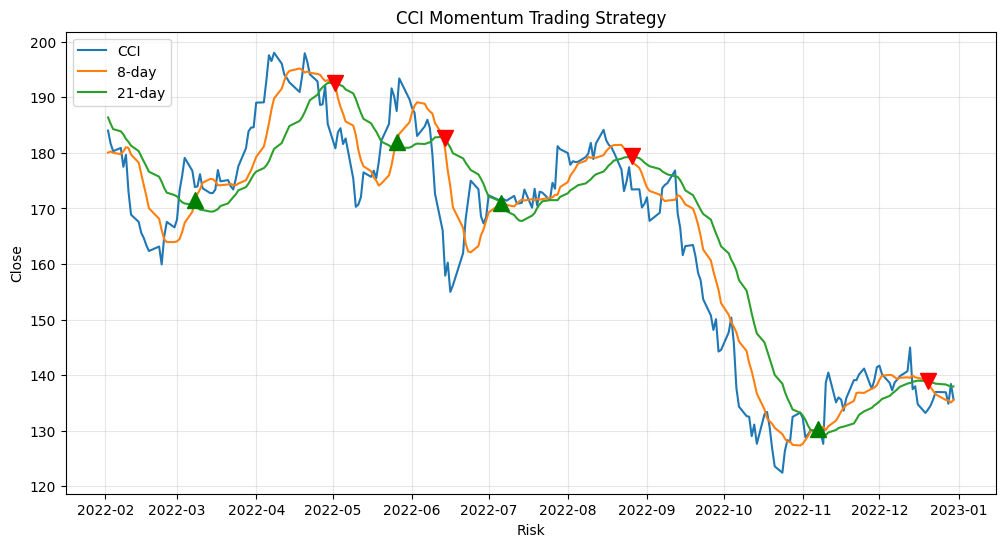

In [ ]:
# Displays all time Trading Strategy
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
title(ticker + " Momentum Trading Strategy")
xlabel("Risk")
ylabel("Close")
plt.plot(gld.iloc[:]['Close'], label = 'CCI')
plt.plot(gld.iloc[:]['8-day'], label = '8-day')
plt.plot(gld.iloc[:]['21-day'], label = '21-day')
plt.plot(gld[:].loc[gld.signal == 1].index, gld[:]['8-day'][gld.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(gld[:].loc[gld.signal == -1].index, gld[:]['21-day'][gld.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

MAA Momentum Strategy

In [ ]:
ticker = "MAA"
gld = si.get_data(ticker,start_date = '01/01/2022',end_date='12/31/2022',interval='1d')
day = np.arange(1, len(gld) + 1) #generate list of trading days
gld['Day'] = day
# Dropping columns we don't want to use
gld.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
gld = gld[['Day', 'open', 'high', 'low', 'close']]
# Renaming the columns
gld.columns = ['Day', 'Open', 'High', 'Low', 'Close']
gld.head()

,Day,Open,High,Low,Close
2022-01-03,1,229.429993,230.710007,222.750000,226.130005
2022-01-04,2,227.020004,230.410004,226.520004,227.389999
2022-01-05,3,226.830002,227.960007,223.149994,223.220001
2022-01-06,4,223.639999,224.410004,219.800003,220.899994
2022-01-07,5,219.889999,220.039993,216.100006,216.419998


In [ ]:
gld['8-day'] = gld['Close'].rolling(8).mean().shift()
gld['21-day'] = gld['Close'].rolling(21).mean().shift()
gld.dropna(inplace=True)
gld.head(n=10)

,Day,Open,High,Low,Close,8-day,21-day
2022-02-02,22,205.979996,214.720001,205.210007,212.029999,202.084999,211.287619
2022-02-03,23,211.990005,215.929993,208.350006,213.020004,203.227499,210.616190
2022-02-04,24,211.470001,215.940002,209.350006,212.529999,204.504999,209.931904
2022-02-07,25,213.070007,214.869995,209.820007,210.330002,206.172499,209.422857
2022-02-08,26,209.960007,211.649994,208.240005,209.610001,207.589998,208.919524
2022-02-09,27,212.759995,217.220001,212.759995,216.539993,209.276249,208.595238
2022-02-10,28,212.880005,215.809998,210.479996,211.500000,210.748749,208.682857
2022-02-11,29,211.229996,214.660004,209.330002,210.830002,211.351250,208.583809
2022-02-14,30,209.990005,212.490005,206.740005,207.580002,212.048750,208.302857
2022-02-15,31,208.910004,210.509995,207.589996,208.350006,211.492500,207.763333


In [ ]:
# Difference between current and previous values
gld['logClose'] = np.log(gld['Close']) # price will always be positive, so this operation is well-defined
gld['return'] = gld['logClose'].diff() # the difference will be positive or negative
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return
2022-02-02,22,205.979996,214.720001,205.210007,212.029999,202.084999,211.287619,5.356728,NaN
2022-02-03,23,211.990005,215.929993,208.350006,213.020004,203.227499,210.616190,5.361386,0.004658
2022-02-04,24,211.470001,215.940002,209.350006,212.529999,204.504999,209.931904,5.359083,-0.002303
2022-02-07,25,213.070007,214.869995,209.820007,210.330002,206.172499,209.422857,5.348678,-0.010405
2022-02-08,26,209.960007,211.649994,208.240005,209.610001,207.589998,208.919524,5.345249,-0.003429


In [ ]:
# Adding the invested column
gld['invested'] = np.where(gld['8-day'] > gld['21-day'], 1, 0) # 8 - 21
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested
2022-02-02,22,205.979996,214.720001,205.210007,212.029999,202.084999,211.287619,5.356728,NaN,0
2022-02-03,23,211.990005,215.929993,208.350006,213.020004,203.227499,210.616190,5.361386,0.004658,0
2022-02-04,24,211.470001,215.940002,209.350006,212.529999,204.504999,209.931904,5.359083,-0.002303,0
2022-02-07,25,213.070007,214.869995,209.820007,210.330002,206.172499,209.422857,5.348678,-0.010405,0
2022-02-08,26,209.960007,211.649994,208.240005,209.610001,207.589998,208.919524,5.345249,-0.003429,0


In [ ]:
print(gld['invested'].value_counts())

0    125
1    105
Name: invested, dtype: int64


In [ ]:
# Making Red and Green triankgle signals
gld['signal'] = gld['invested'].diff()
print(gld['signal'].value_counts())

 0.0    215
 1.0      7
-1.0      7
Name: signal, dtype: int64


In [ ]:
gld.loc["2022-01-03",'signal'] = 1.0
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested,signal
2022-02-02,22.0,205.979996,214.720001,205.210007,212.029999,202.084999,211.287619,5.356728,NaN,0.0,NaN
2022-02-03,23.0,211.990005,215.929993,208.350006,213.020004,203.227499,210.616190,5.361386,0.004658,0.0,0.0
2022-02-04,24.0,211.470001,215.940002,209.350006,212.529999,204.504999,209.931904,5.359083,-0.002303,0.0,0.0
2022-02-07,25.0,213.070007,214.869995,209.820007,210.330002,206.172499,209.422857,5.348678,-0.010405,0.0,0.0
2022-02-08,26.0,209.960007,211.649994,208.240005,209.610001,207.589998,208.919524,5.345249,-0.003429,0.0,0.0


In [ ]:
# Displays the Trading Days
gld[gld['signal'].isin([1,-1])]

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested,signal
2022-02-09,27.0,212.759995,217.220001,212.759995,216.539993,209.276249,208.595238,5.377775,0.032527,1.0,1.0
2022-02-24,37.0,199.570007,204.740005,197.100006,204.320007,206.572502,207.101429,5.319687,0.012311,0.0,-1.0
2022-03-09,46.0,211.789993,215.460007,210.429993,211.699997,208.826250,208.356668,5.355170,0.016767,1.0,1.0
2022-03-23,56.0,204.910004,205.449997,202.630005,203.220001,207.025000,207.696667,5.314289,-0.011060,0.0,-1.0
2022-04-04,64.0,213.369995,214.160004,208.259995,210.860001,209.227501,208.922857,5.351194,-0.011599,1.0,1.0
2022-04-20,75.0,208.119995,211.509995,208.119995,210.490005,208.522499,209.231905,5.349438,0.014259,0.0,-1.0
2022-06-02,105.0,179.339996,181.229996,176.440002,180.940002,179.948751,179.846191,5.198165,0.006487,1.0,1.0
2022-06-10,111.0,167.000000,169.929993,165.789993,168.160004,176.962500,177.568572,5.124916,-0.004568,0.0,-1.0
2022-07-01,125.0,174.389999,175.830002,172.419998,175.449997,170.900000,170.356667,5.167354,0.004456,1.0,1.0
2022-07-18,135.0,168.050003,168.949997,165.750000,166.440002,169.145000,169.249047,5.114635,-0.006289,0.0,-1.0


In [ ]:
# Shows how much money is made
gld['system_return'] = gld['invested'] * gld['return']
gld.head()

,Day,Open,High,Low,Close,8-day,21-day,logClose,return,invested,signal,system_return
2022-02-02,22.0,205.979996,214.720001,205.210007,212.029999,202.084999,211.287619,5.356728,NaN,0.0,NaN,NaN
2022-02-03,23.0,211.990005,215.929993,208.350006,213.020004,203.227499,210.616190,5.361386,0.004658,0.0,0.0,0.0
2022-02-04,24.0,211.470001,215.940002,209.350006,212.529999,204.504999,209.931904,5.359083,-0.002303,0.0,0.0,-0.0
2022-02-07,25.0,213.070007,214.869995,209.820007,210.330002,206.172499,209.422857,5.348678,-0.010405,0.0,0.0,-0.0
2022-02-08,26.0,209.960007,211.649994,208.240005,209.610001,207.589998,208.919524,5.345249,-0.003429,0.0,0.0,-0.0


In [ ]:
np.exp(np.sum(gld['system_return'])) -1

-0.15532661433885775

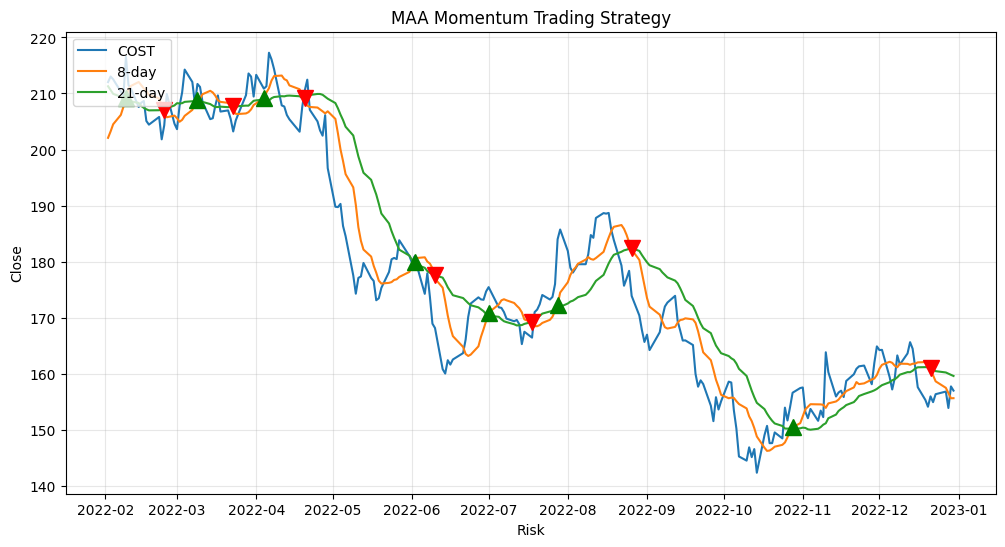

In [ ]:
# Shows last years Trading
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
title(ticker + " Momentum Trading Strategy")
xlabel("Risk")
ylabel("Close")
plt.plot(gld.iloc[-252:]['Close'], label = 'COST') # actual value
plt.plot(gld.iloc[-252:]['8-day'], label = '8-day') # 8-day average
plt.plot(gld.iloc[-252:]['21-day'], label = '21-day') # 21-day average
plt.plot(gld[-252:].loc[gld.signal == 1].index, gld[-252:]['8-day'][gld.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-252:].loc[gld.signal == -1].index, gld[-252:]['21-day'][gld.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

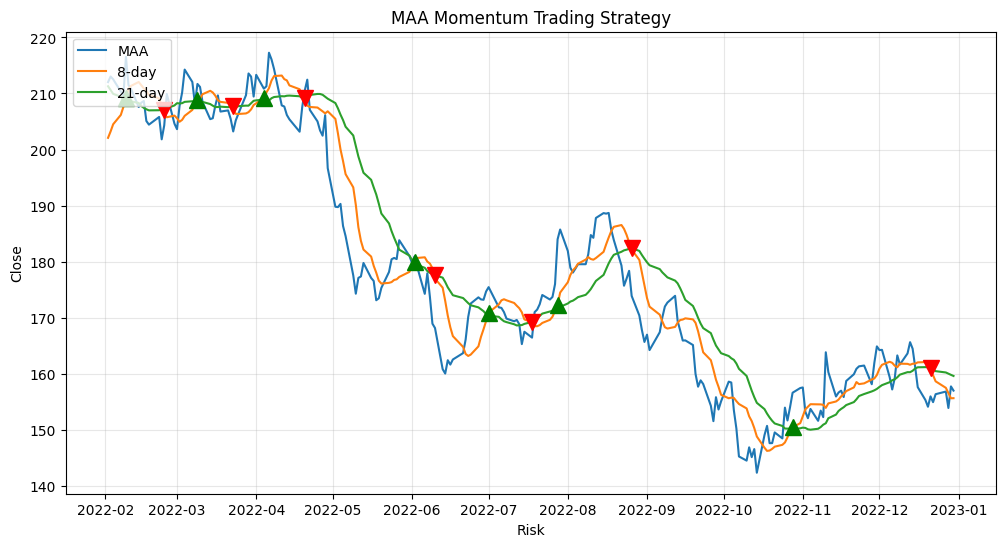

In [ ]:
# Displays all time Trading Strategy
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
title(ticker + " Momentum Trading Strategy")
xlabel("Risk")
ylabel("Close")
plt.plot(gld.iloc[:]['Close'], label = 'MAA')
plt.plot(gld.iloc[:]['8-day'], label = '8-day')
plt.plot(gld.iloc[:]['21-day'], label = '21-day')
plt.plot(gld[:].loc[gld.signal == 1].index, gld[:]['8-day'][gld.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(gld[:].loc[gld.signal == -1].index, gld[:]['21-day'][gld.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

## 3.3 - Momentum trading strategy for the entire MPT portfolio

# ⚛ **Note to team mate**








## 3.4 - Buy-and-Hold strategy for the S&P 500 index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-01-03 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     251 non-null    int64  
 1   Open    251 non-null    float64
 2   High    251 non-null    float64
 3   Low     251 non-null    float64
 4   Close   251 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


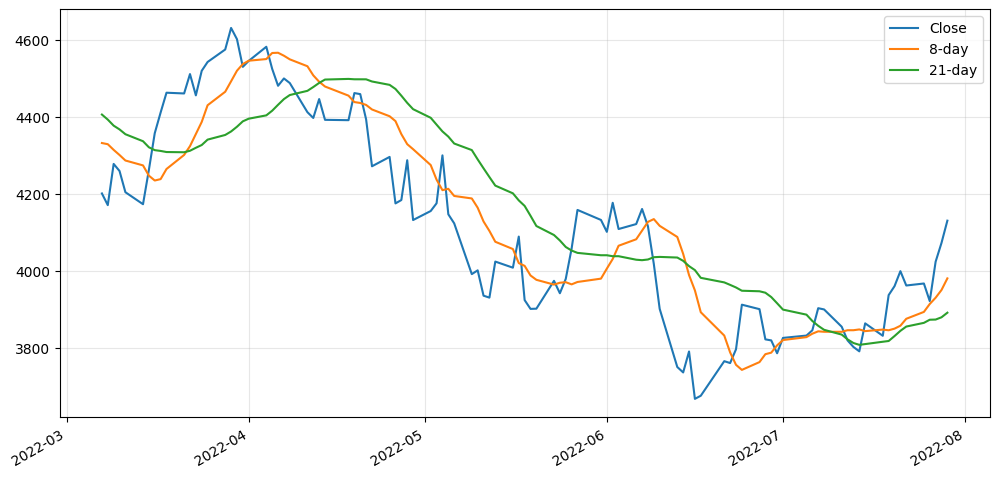

-0.1633945983902625

In [ ]:
ticker = "^GSPC"
gld = si.get_data(ticker,start_date = '01/01/2022',end_date='12/31/2022',interval='1d')
day = np.arange(1, len(gld) + 1) #generate list of trading days
gld['Day'] = day
# Dropping columns I don't want to use
gld.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
gld = gld[['Day', 'open', 'high', 'low', 'close']]
# Renaming the columns
gld.columns = ['Day', 'Open', 'High', 'Low', 'Close']
gld.head() #remove

gld.info() #remove

gld.describe() #remove

# WITH data leakage
# why is it leaking? It includes the 8th day!
gld['8-day'] = gld['Close'].rolling(8).mean()
gld['21-day'] = gld['Close'].rolling(21).mean()
gld.head(n=10)

# rolled back (no data leakage)
# since this cell is run after, this overwrites the previous data leakage
# you can comment out the cell above and run all if you are nervous!
gld['8-day'] = gld['Close'].rolling(8).mean().shift()
gld['21-day'] = gld['Close'].rolling(21).mean().shift()
gld.dropna(inplace=True)
gld.head(n=10)


# imagine where you would put markers on the plot
# for buy vs. sell...

# the 22:123 shows the first 100 days of trading
gld.iloc[22:123,[4,5,6]].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
plt.show()


gld['logClose'] = np.log(gld['Close']) # price will always be positive, so this operation is well-defined
gld['return'] = gld['logClose'].diff() # the difference will be positive or negative
gld.head()


gld.loc["2018-01-29",'return'] = 0.0 #date adjust 8 days after
gld.head()


np.exp(np.sum(gld['return'])) -1

## 3.5 - Plot Comparing the Investment Strategies

KeyError: ignored

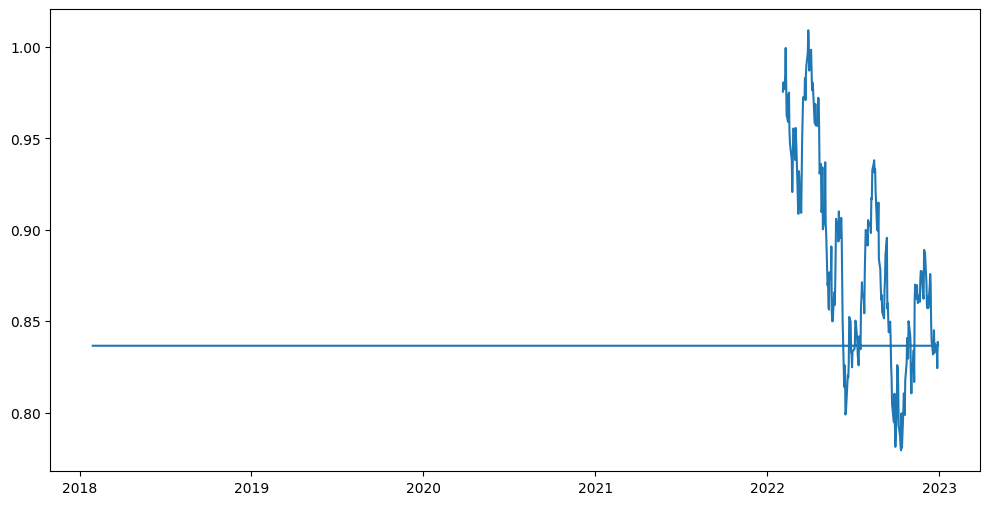

In [ ]:
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)
plt.show()

## 3.6 - Discussion and Comparison of the Investment Strategies

# 4 - Conclusion

# ⚛ **Note to team mate**








## 4.1 - Thoughts and Insights

## 4.2 - Individual Contributions